In [61]:
#Basic Computation
import numpy as np
from numpy import arange
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
#Feature Selection Metrics
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from minepy import MINE
from minepy import cstats

#Preprocessing and performance evaluation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import log,pi,hypot,fabs,sqrt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# grid search hyperparameters for ridge regression
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
# Model
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.linear_model import LogisticRegression,SGDRegressor,TheilSenRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
OUTDATED_IGNORE=1

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"


from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [62]:
def segment(data,col_name):
    Y = (data[col_name])
    X = data.drop(col_name,axis=1)
    return X,Y

In [63]:
def Train_Valid_Test(data,train_percent,valid_percent,test_percent):
    train_len = int(data.shape[0]*train_percent)
    valid_len = int(data.shape[0]*(train_percent + valid_percent)) 
    train_df = data.iloc[:train_len,:]
    valid_df = data.iloc[train_len:valid_len,:]
    test_df = data.iloc[valid_len:,:]
    return train_df,valid_df,test_df

def Split_Part(data,percent):
    train_len = int(data.shape[0]*percent)
    train_df = data.iloc[:train_len,:]
    test_df = data.iloc[train_len:,:]
    return train_df,test_df

In [64]:
def lag_data(data,max_lag,target):
    X = data.copy()
    X_col = list(X.columns)
    X_col.remove(target)
    for col in X_col:
        for i in range(2,max_lag+1):
            X[col+'_lag_'+str(i)] = X[col].shift(i-1)
    for i in X_col:
        X.rename(columns ={i:i+'_lag_1'},inplace = True)
    X.dropna(inplace = True) 
    return X
### Lag the feature based on the order of feature in data.columns
def lag_feature_df(max_lag,data,target):
    # Store each feature's dataframe:
    X = pd.DataFrame()
    X_col = list(data.columns)
    X_col.remove(target)
    feature_range = range(len(X_col))
    for idx,col in enumerate(X_col):
        for j in range(max_lag):
            X[col+'_lag_'+str(j+1)] = data[col].shift(j)
    X[target] = data[target].copy()
    X.dropna(inplace=True)
    return X

In [65]:
energy = pd.read_csv(r'./dataset/energydata_complete/energydata_complete.csv',parse_dates = ['date'],index_col = 0)

In [66]:
df = energy.resample('D').sum()

In [67]:
df.shape

(339, 28)

In [68]:
x_train_no.shape

(236, 28)

In [69]:
print([i for i in x_train_no.columns])

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']


In [70]:
df['Appliances_1'] = df['Appliances'].shift(-1)
df.dropna(inplace=True)

In [71]:
train_no,test_no = Split_Part(df,0.7)
x_train_no,y_train_no = segment(train_no,'Appliances_1')
x_test_no,y_test_no = segment(test_no,'Appliances_1')

lag_df = lag_feature_df(30,df,'Appliances_1')
train_df,test_df = Split_Part(lag_df,0.7)
x_train_L,y_train_L = segment(train_df,'Appliances_1')
x_test_L,y_test_L = segment(test_df,'Appliances_1')

train,valid = Split_Part(train_df,0.7)
## Lagging
x_train,y_train = segment(train,'Appliances_1')
x_valid,y_valid = segment(valid,'Appliances_1')

In [72]:
X_arr = x_train.values

### Construct Corr Matrix 

In [73]:
x_mat = np.zeros([x_train.shape[1],x_train.shape[1]])
feature_num = x_train_no.shape[1]
max_lag = 30

for i in range(0,feature_num):
    ## For each feature,we computew its corr with its self and other features
    ## Self Correlation
    row_start = max_lag*i
    col_end = max_lag*(i+1)
    print(row_start,col_end)
    x_mat[row_start,row_start+1:col_end] = [stats.pearsonr(X_arr[:,row_start],X_arr[:,p])[0] for p in range(max_lag*i+1,max_lag*(i+1))]
    ## Diagnal
    for k in range(row_start+1,col_end-1):
        for j in range(row_start,max_lag*(i+1)-(k-max_lag*i)):
            x_mat[j,j+(k-max_lag*i)] = x_mat[row_start,k]
            
    ## Between Features
    for row in range(col_end,X_arr.shape[1]):
        for col in range(row_start,col_end):
            x_mat[col][row] = stats.pearsonr(X_arr[:,row],X_arr[:,col])[0]

0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390
390 420
420 450
450 480
480 510
510 540
540 570
570 600
600 630
630 660
660 690
690 720
720 750
750 780
780 810
810 840


In [32]:
corr_copy = x_mat.copy()
corr_copy = np.abs(corr_copy)

In [33]:
def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

In [34]:
def generate_feature_subsets(corr_matrix,threshold):
    
    correlation_pairs = np.argwhere(corr_matrix>=threshold)
    
    # Check how many features are highly correlated with 1 feature
    correlated_pairs_dict = {}

    for i in set(correlation_pairs[:,0]):
        correlated_pairs_dict[i] = []
        for j in correlation_pairs:
            if j[0]==i:
                correlated_pairs_dict[i].append(j[1])
                
    high_correlated_features = list(set(correlation_pairs.flatten()))
    print("High_correlated_features",len(high_correlated_features))
    corr_cols = x_train.columns[high_correlated_features]
    # Use Mutual Information Regression to rank those highly redundent features
    max_feats = len(corr_cols)
    sel_function = mutual_info_regression
    fs = SelectKBest(score_func=sel_function, k=max_feats)
    fs.fit(x_train[corr_cols],y_train)
    mutual_info = dict(zip(high_correlated_features,fs.scores_))
    sorted_by_mutual_info =[key for (key,val) in sorted(mutual_info.items(), key=lambda kv: kv[1],reverse=True)]
    
    check_corr_pairs = {}
    kk = list(correlated_pairs_dict.keys())
    kk_copy = kk.copy()
    for j in kk_copy:
        check_corr_pairs[j] = correlated_pairs_dict[j].copy()
        for i in correlated_pairs_dict[j]:
            if i in kk:
                check_corr_pairs[j].append(correlated_pairs_dict[i])
                for q in correlated_pairs_dict[i]:
                    if q in kk_copy:
                        kk_copy.remove(q)
            if i in kk_copy:
                    kk_copy.remove(i)
        check_corr_pairs[j] = list(set(flat(check_corr_pairs[j])))
        
    redundant_group = []

    for k,v in check_corr_pairs.items():
        redundant_group.append([k]+v)
    
    mrmr_features = []
    for i in redundant_group:
        indexes = [sorted_by_mutual_info.index(j) for j in i]
        mrmr_features.append(sorted_by_mutual_info[min(indexes)])
    print("MRMR Features",len(mrmr_features))
    
    
    ## Uncorelated features
    lst = []
    for i in range(x_train.shape[1]):
        if i not in high_correlated_features:
            lst.append(i)
    ## Joint filtered features with uncorrelated pairs
    final_list = list(set(mrmr_features+lst))
    
    print("Final Features:",len(final_list))
    return final_list

In [35]:
pd.DataFrame(corr_copy)

,0,1,2,3,4,5,6,7,8,9,...,830,831,832,833,834,835,836,837,838,839
0,0.0,0.587225,0.435898,0.289535,0.180934,0.203603,0.123454,0.022536,0.040703,0.095513,...,0.012277,0.007601,0.021385,0.048952,0.059440,0.028569,0.138957,0.194624,0.281639,0.448853
1,0.0,0.000000,0.587225,0.435898,0.289535,0.180934,0.203603,0.123454,0.022536,0.040703,...,0.088208,0.013074,0.017741,0.046676,0.074194,0.069187,0.037540,0.147120,0.204743,0.276247
2,0.0,0.000000,0.000000,0.587225,0.435898,0.289535,0.180934,0.203603,0.123454,0.022536,...,0.104583,0.097923,0.022491,0.027177,0.056226,0.068245,0.065728,0.040693,0.152210,0.194666
3,0.0,0.000000,0.000000,0.000000,0.587225,0.435898,0.289535,0.180934,0.203603,0.123454,...,0.094978,0.112294,0.105611,0.029907,0.034609,0.048186,0.065421,0.063643,0.044539,0.140691
4,0.0,0.000000,0.000000,0.000000,0.000000,0.587225,0.435898,0.289535,0.180934,0.203603,...,0.115078,0.104319,0.121705,0.114994,0.038986,0.028141,0.044761,0.062812,0.059643,0.032266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.734869,0.592900,0.444400,0.292007
836,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.734869,0.592900,0.444400
837,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.734869,0.592900
838,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.734869


In [36]:
feature_collections = {}
for i in np.round(arange(0.5,0.99,0.05),3):
    print(i)
    feature_collections[i] = list(x_train.columns[generate_feature_subsets(corr_copy,i)])

0.5
High_correlated_features 840
MRMR Features 20
Final Features: 13
0.55
High_correlated_features 840
MRMR Features 20
Final Features: 10
0.6
High_correlated_features 840
MRMR Features 63
Final Features: 35
0.65
High_correlated_features 840
MRMR Features 60
Final Features: 39
0.7
High_correlated_features 814
MRMR Features 34
Final Features: 46
0.75
High_correlated_features 811
MRMR Features 47
Final Features: 75
0.8
High_correlated_features 796
MRMR Features 71
Final Features: 114
0.85
High_correlated_features 750
MRMR Features 60
Final Features: 150
0.9
High_correlated_features 721
MRMR Features 63
Final Features: 179
0.95
High_correlated_features 690
MRMR Features 60
Final Features: 210


In [49]:
feature_collections

{0.5: ['RH_2_lag_11',
  'RH_7_lag_1',
  'T5_lag_23',
  'RH_6_lag_1',
  'T3_lag_22',
  'T4_lag_29',
  'T3_lag_26',
  'T8_lag_16',
  'T9_lag_30',
  'Visibility_lag_5',
  'Windspeed_lag_8',
  'Tdewpoint_lag_16',
  'T7_lag_27'],
 0.55: ['RH_2_lag_11',
  'T4_lag_18',
  'RH_7_lag_1',
  'T5_lag_23',
  'T7_lag_22',
  'T4_lag_28',
  'T4_lag_29',
  'T8_lag_15',
  'RH_5_lag_5',
  'Windspeed_lag_8'],
 0.6: ['T4_lag_18',
  'Tdewpoint_lag_20',
  'RH_8_lag_8',
  'Tdewpoint_lag_24',
  'Tdewpoint_lag_25',
  'T4_lag_29',
  'RH_2_lag_1',
  'RH_out_lag_11',
  'RH_out_lag_13',
  'RH_6_lag_29',
  'RH_out_lag_16',
  'rv2_lag_3',
  'lights_lag_19',
  'T9_lag_22',
  'T9_lag_23',
  'T9_lag_24',
  'T3_lag_1',
  'T3_lag_2',
  'T9_lag_25',
  'T9_lag_26',
  'T7_lag_21',
  'Windspeed_lag_8',
  'T9_lag_29',
  'T7_lag_27',
  'Windspeed_lag_13',
  'T7_lag_28',
  'T7_lag_30',
  'RH_7_lag_6',
  'T3_lag_22',
  'T1_lag_20',
  'Visibility_lag_2',
  'Visibility_lag_19',
  'T8_lag_15',
  'T8_lag_16',
  'Tdewpoint_lag_16'],
 0

In [48]:
feature_nums = {}
for k,v in feature_collections.items():
    feature_nums[k] = len(v)

### XGBoost
### LightBGM
### RandomForest

### DataSets

Dow Jones Data

Electricity Data

Diamond Data

Air Quality

In [50]:
def lgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train,eval_set = [(x_test,y_test)],early_stopping_rounds = 10)

    features = X_train.columns
    importances = gbm.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = features
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with LightBGM model')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [51]:
def rfr_pipeline(X_train,Y_train,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    
    
    rfr = RandomForestRegressor()
    rfr.fit(x_train,y_train.reshape(-1,))
    
    feature_names = X_train.columns
    importances = rfr.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with Random Forest model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    
    return top_features

In [52]:
def xgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    xgb = XGBRegressor()
    xgb.fit(x_train,y_train.reshape(-1,),eval_set=[(x_test, y_test)],early_stopping_rounds=10)

    feature_names = X_train.columns
    importances = xgb.feature_importances_
#     plot_importance(xgb,max_num_features=10,importance_type='gain',show_values=False)
    
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
# #     plt.barh(importances_df['Feature_Name'][:10], importances_df['Feature_Importance'][:10]) 
#     plt.title('Top 10 features with XGB model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [53]:
def rfr_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    
    range_end = 0
    
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                rfr_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    rfr_features.append( rfr_pipeline(x_train_L[now_cols],y_train_L,j))
                rfr_features = list(set(np.array(rfr_features).flatten()))
                features_dict[j] = rfr_features
                print(j,end='\r',flush=True)
                
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
        features_dict = {}
        for j in range(feature_num_1,range_end+1):
            rfr_features = []
            for i in range(5):
                col_len = int(len(cols)*i*0.2)
                now_cols = cols[col_len:]
                rfr_features.append( rfr_pipeline(x_train_L[now_cols],y_train_L,j))

            rfr_features = list(set(np.array(rfr_features).flatten()))
            features_dict[j] = rfr_features
        
            print(j,end='\r',flush=True)
        return features_dict

In [54]:
def lgb_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    range_end = 0

    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                lgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    lgb_features.append( lgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))

                lgb_features = list(set(np.array(lgb_features).flatten()))
                features_dict[j] = lgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    features_dict = {}
    
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
    
    for j in range(feature_num_1,range_end+1):
        lgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            lgb_features.append(lgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
        lgb_features = list(set(np.array(lgb_features).flatten()))
        features_dict[j] = lgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [55]:
def xgb_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                xgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    xgb_features.append( xgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
                xgb_features = list(set(np.array(xgb_features).flatten()))
                features_dict[j] = xgb_features
                print(j,end='\r',flush=True)
            return features_dict
        

        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        xgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            xgb_features.append( xgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
        xgb_features = list(set(np.array(xgb_features).flatten()))
        features_dict[j] = xgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [57]:
real_lgb = {}
for k,v in feature_collections.items():
    print(k)
    real_lgb[k] = lgb_recursive(v,1,5)

real_xgb = {}
for k,v in feature_collections.items():
    print(k)
    real_xgb[k] = lgb_recursive(v,1,5)

0.5
[1]	valid_0's l2: 0.094915
[2]	valid_0's l2: 0.084102
[3]	valid_0's l2: 0.0744772
[4]	valid_0's l2: 0.0671687
[5]	valid_0's l2: 0.0604637
[6]	valid_0's l2: 0.0557636
[7]	valid_0's l2: 0.0512458
[8]	valid_0's l2: 0.0491502
[9]	valid_0's l2: 0.0476681
[10]	valid_0's l2: 0.0434752
[11]	valid_0's l2: 0.0400963
[12]	valid_0's l2: 0.0371383
[13]	valid_0's l2: 0.0349758
[14]	valid_0's l2: 0.0332695
[15]	valid_0's l2: 0.0325703
[16]	valid_0's l2: 0.0326076
[17]	valid_0's l2: 0.032386
[18]	valid_0's l2: 0.0315895
[19]	valid_0's l2: 0.0311305
[20]	valid_0's l2: 0.0313868
[21]	valid_0's l2: 0.0314641
[22]	valid_0's l2: 0.0311518
[23]	valid_0's l2: 0.0304178
[24]	valid_0's l2: 0.0298851
[25]	valid_0's l2: 0.0301042
[26]	valid_0's l2: 0.0302036
[27]	valid_0's l2: 0.0307081
[28]	valid_0's l2: 0.0309177
[29]	valid_0's l2: 0.0316745
[30]	valid_0's l2: 0.0319719
[31]	valid_0's l2: 0.0320374
[32]	valid_0's l2: 0.0324965
[33]	valid_0's l2: 0.0328493
[34]	valid_0's l2: 0.0333754
[1]	valid_0's l2: 0.09

0.55
[1]	valid_0's l2: 0.0953706
[2]	valid_0's l2: 0.083809
[3]	valid_0's l2: 0.0751894
[4]	valid_0's l2: 0.0675026
[5]	valid_0's l2: 0.0616811
[6]	valid_0's l2: 0.0566122
[7]	valid_0's l2: 0.0529616
[8]	valid_0's l2: 0.0499067
[9]	valid_0's l2: 0.0472553
[10]	valid_0's l2: 0.0456656
[11]	valid_0's l2: 0.044426
[12]	valid_0's l2: 0.0437834
[13]	valid_0's l2: 0.0435958
[14]	valid_0's l2: 0.0431616
[15]	valid_0's l2: 0.0426905
[16]	valid_0's l2: 0.0424648
[17]	valid_0's l2: 0.0425867
[18]	valid_0's l2: 0.0423981
[19]	valid_0's l2: 0.0423412
[20]	valid_0's l2: 0.0426668
[21]	valid_0's l2: 0.0426847
[22]	valid_0's l2: 0.0427473
[23]	valid_0's l2: 0.0430191
[24]	valid_0's l2: 0.0427781
[25]	valid_0's l2: 0.0429489
[26]	valid_0's l2: 0.0435338
[27]	valid_0's l2: 0.0438175
[28]	valid_0's l2: 0.0441371
[29]	valid_0's l2: 0.0444488
[1]	valid_0's l2: 0.0953706
[2]	valid_0's l2: 0.083809
[3]	valid_0's l2: 0.0744797
[4]	valid_0's l2: 0.0670843
[5]	valid_0's l2: 0.060943
[6]	valid_0's l2: 0.056228


0.6
[1]	valid_0's l2: 0.0947201
[2]	valid_0's l2: 0.0826786
[3]	valid_0's l2: 0.072924
[4]	valid_0's l2: 0.065678
[5]	valid_0's l2: 0.0597012
[6]	valid_0's l2: 0.0550569
[7]	valid_0's l2: 0.0514951
[8]	valid_0's l2: 0.0478149
[9]	valid_0's l2: 0.0449136
[10]	valid_0's l2: 0.0430335
[11]	valid_0's l2: 0.0414468
[12]	valid_0's l2: 0.0395735
[13]	valid_0's l2: 0.0386794
[14]	valid_0's l2: 0.038246
[15]	valid_0's l2: 0.0370865
[16]	valid_0's l2: 0.0365607
[17]	valid_0's l2: 0.035938
[18]	valid_0's l2: 0.035722
[19]	valid_0's l2: 0.0354379
[20]	valid_0's l2: 0.0346229
[21]	valid_0's l2: 0.0343346
[22]	valid_0's l2: 0.0345875
[23]	valid_0's l2: 0.0351876
[24]	valid_0's l2: 0.034547
[25]	valid_0's l2: 0.0346457
[26]	valid_0's l2: 0.0349857
[27]	valid_0's l2: 0.0353572
[28]	valid_0's l2: 0.0358619
[29]	valid_0's l2: 0.0362219
[30]	valid_0's l2: 0.0360749
[31]	valid_0's l2: 0.0364638
[1]	valid_0's l2: 0.094847
[2]	valid_0's l2: 0.0828166
[3]	valid_0's l2: 0.072681
[4]	valid_0's l2: 0.0660342
[5

[1]	valid_0's l2: 0.0947201
[2]	valid_0's l2: 0.0826786
[3]	valid_0's l2: 0.072924
[4]	valid_0's l2: 0.065678
[5]	valid_0's l2: 0.0597012
[6]	valid_0's l2: 0.0550569
[7]	valid_0's l2: 0.0514951
[8]	valid_0's l2: 0.0478149
[9]	valid_0's l2: 0.0449136
[10]	valid_0's l2: 0.0430335
[11]	valid_0's l2: 0.0414468
[12]	valid_0's l2: 0.0395735
[13]	valid_0's l2: 0.0386794
[14]	valid_0's l2: 0.038246
[15]	valid_0's l2: 0.0370865
[16]	valid_0's l2: 0.0365607
[17]	valid_0's l2: 0.035938
[18]	valid_0's l2: 0.035722
[19]	valid_0's l2: 0.0354379
[20]	valid_0's l2: 0.0346229
[21]	valid_0's l2: 0.0343346
[22]	valid_0's l2: 0.0345875
[23]	valid_0's l2: 0.0351876
[24]	valid_0's l2: 0.034547
[25]	valid_0's l2: 0.0346457
[26]	valid_0's l2: 0.0349857
[27]	valid_0's l2: 0.0353572
[28]	valid_0's l2: 0.0358619
[29]	valid_0's l2: 0.0362219
[30]	valid_0's l2: 0.0360749
[31]	valid_0's l2: 0.0364638
[1]	valid_0's l2: 0.094847
[2]	valid_0's l2: 0.0828166
[3]	valid_0's l2: 0.072681
[4]	valid_0's l2: 0.0660342
[5]	va

[1]	valid_0's l2: 0.0947201
[2]	valid_0's l2: 0.0826786
[3]	valid_0's l2: 0.072924
[4]	valid_0's l2: 0.065678
[5]	valid_0's l2: 0.0597012
[6]	valid_0's l2: 0.0550569
[7]	valid_0's l2: 0.0514951
[8]	valid_0's l2: 0.0478149
[9]	valid_0's l2: 0.0449136
[10]	valid_0's l2: 0.0430335
[11]	valid_0's l2: 0.0414468
[12]	valid_0's l2: 0.0395735
[13]	valid_0's l2: 0.0386794
[14]	valid_0's l2: 0.038246
[15]	valid_0's l2: 0.0370865
[16]	valid_0's l2: 0.0365607
[17]	valid_0's l2: 0.035938
[18]	valid_0's l2: 0.035722
[19]	valid_0's l2: 0.0354379
[20]	valid_0's l2: 0.0346229
[21]	valid_0's l2: 0.0343346
[22]	valid_0's l2: 0.0345875
[23]	valid_0's l2: 0.0351876
[24]	valid_0's l2: 0.034547
[25]	valid_0's l2: 0.0346457
[26]	valid_0's l2: 0.0349857
[27]	valid_0's l2: 0.0353572
[28]	valid_0's l2: 0.0358619
[29]	valid_0's l2: 0.0362219
[30]	valid_0's l2: 0.0360749
[31]	valid_0's l2: 0.0364638
[1]	valid_0's l2: 0.094847
[2]	valid_0's l2: 0.0828166
[3]	valid_0's l2: 0.072681
[4]	valid_0's l2: 0.0660342
[5]	va

[14]	valid_0's l2: 0.0958063
[15]	valid_0's l2: 0.0966375
[16]	valid_0's l2: 0.0963254
[17]	valid_0's l2: 0.0971059
[18]	valid_0's l2: 0.0970815
[19]	valid_0's l2: 0.0981851
[20]	valid_0's l2: 0.0979222
[21]	valid_0's l2: 0.0983431
[22]	valid_0's l2: 0.0989689
[1]	valid_0's l2: 0.0947197
[2]	valid_0's l2: 0.0830512
[3]	valid_0's l2: 0.0723727
[4]	valid_0's l2: 0.064535
[5]	valid_0's l2: 0.0583948
[6]	valid_0's l2: 0.0525715
[7]	valid_0's l2: 0.0480528
[8]	valid_0's l2: 0.0441594
[9]	valid_0's l2: 0.0414775
[10]	valid_0's l2: 0.0389641
[11]	valid_0's l2: 0.0367231
[12]	valid_0's l2: 0.0346462
[13]	valid_0's l2: 0.0333145
[14]	valid_0's l2: 0.0322151
[15]	valid_0's l2: 0.0320534
[16]	valid_0's l2: 0.0313884
[17]	valid_0's l2: 0.0301436
[18]	valid_0's l2: 0.029341
[19]	valid_0's l2: 0.028715
[20]	valid_0's l2: 0.0284264
[21]	valid_0's l2: 0.0283829
[22]	valid_0's l2: 0.0290299
[23]	valid_0's l2: 0.029503
[24]	valid_0's l2: 0.0301255
[25]	valid_0's l2: 0.0295216
[26]	valid_0's l2: 0.029609

[1]	valid_0's l2: 0.0947197
[2]	valid_0's l2: 0.0830512
[3]	valid_0's l2: 0.0723727
[4]	valid_0's l2: 0.064535
[5]	valid_0's l2: 0.0583948
[6]	valid_0's l2: 0.0525715
[7]	valid_0's l2: 0.0480528
[8]	valid_0's l2: 0.0441594
[9]	valid_0's l2: 0.0414775
[10]	valid_0's l2: 0.0389641
[11]	valid_0's l2: 0.0367231
[12]	valid_0's l2: 0.0346462
[13]	valid_0's l2: 0.0333145
[14]	valid_0's l2: 0.0322151
[15]	valid_0's l2: 0.0320534
[16]	valid_0's l2: 0.0313884
[17]	valid_0's l2: 0.0301436
[18]	valid_0's l2: 0.029341
[19]	valid_0's l2: 0.028715
[20]	valid_0's l2: 0.0284264
[21]	valid_0's l2: 0.0283829
[22]	valid_0's l2: 0.0290299
[23]	valid_0's l2: 0.029503
[24]	valid_0's l2: 0.0301255
[25]	valid_0's l2: 0.0295216
[26]	valid_0's l2: 0.029609
[27]	valid_0's l2: 0.0299193
[28]	valid_0's l2: 0.0294347
[29]	valid_0's l2: 0.0293593
[30]	valid_0's l2: 0.0294175
[31]	valid_0's l2: 0.0295667
[1]	valid_0's l2: 0.095865
[2]	valid_0's l2: 0.0849095
[3]	valid_0's l2: 0.0757995
[4]	valid_0's l2: 0.0681946
[5]	

0.7
[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0852636
[3]	valid_0's l2: 0.0770806
[4]	valid_0's l2: 0.068299
[5]	valid_0's l2: 0.0625622
[6]	valid_0's l2: 0.0573277
[7]	valid_0's l2: 0.0536923
[8]	valid_0's l2: 0.0501353
[9]	valid_0's l2: 0.046058
[10]	valid_0's l2: 0.0425151
[11]	valid_0's l2: 0.0403522
[12]	valid_0's l2: 0.0387606
[13]	valid_0's l2: 0.0378181
[14]	valid_0's l2: 0.0371873
[15]	valid_0's l2: 0.0367367
[16]	valid_0's l2: 0.0362768
[17]	valid_0's l2: 0.0358548
[18]	valid_0's l2: 0.0353659
[19]	valid_0's l2: 0.0356175
[20]	valid_0's l2: 0.0355708
[21]	valid_0's l2: 0.0350366
[22]	valid_0's l2: 0.0348998
[23]	valid_0's l2: 0.0352449
[24]	valid_0's l2: 0.0352775
[25]	valid_0's l2: 0.0356173
[26]	valid_0's l2: 0.0361337
[27]	valid_0's l2: 0.0362998
[28]	valid_0's l2: 0.0367591
[29]	valid_0's l2: 0.03741
[30]	valid_0's l2: 0.0370825
[31]	valid_0's l2: 0.0370335
[32]	valid_0's l2: 0.036722
[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0849304
[3]	valid_0's l2: 0.077352

[31]	valid_0's l2: 0.0480221
[32]	valid_0's l2: 0.0477258
[33]	valid_0's l2: 0.0476999
[34]	valid_0's l2: 0.047625
[35]	valid_0's l2: 0.0476324
[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0852636
[3]	valid_0's l2: 0.0770806
[4]	valid_0's l2: 0.068299
[5]	valid_0's l2: 0.0625622
[6]	valid_0's l2: 0.0573277
[7]	valid_0's l2: 0.0536923
[8]	valid_0's l2: 0.0501353
[9]	valid_0's l2: 0.046058
[10]	valid_0's l2: 0.0425151
[11]	valid_0's l2: 0.0403522
[12]	valid_0's l2: 0.0387606
[13]	valid_0's l2: 0.0378181
[14]	valid_0's l2: 0.0371873
[15]	valid_0's l2: 0.0367367
[16]	valid_0's l2: 0.0362768
[17]	valid_0's l2: 0.0358548
[18]	valid_0's l2: 0.0353659
[19]	valid_0's l2: 0.0356175
[20]	valid_0's l2: 0.0355708
[21]	valid_0's l2: 0.0350366
[22]	valid_0's l2: 0.0348998
[23]	valid_0's l2: 0.0352449
[24]	valid_0's l2: 0.0352775
[25]	valid_0's l2: 0.0356173
[26]	valid_0's l2: 0.0361337
[27]	valid_0's l2: 0.0362998
[28]	valid_0's l2: 0.0367591
[29]	valid_0's l2: 0.03741
[30]	valid_0's l2: 0.0370825

[2]	valid_0's l2: 0.0934856
[3]	valid_0's l2: 0.0835644
[4]	valid_0's l2: 0.0761507
[5]	valid_0's l2: 0.0731613
[6]	valid_0's l2: 0.0709505
[7]	valid_0's l2: 0.0661648
[8]	valid_0's l2: 0.0647411
[9]	valid_0's l2: 0.062885
[10]	valid_0's l2: 0.0596241
[11]	valid_0's l2: 0.0568928
[12]	valid_0's l2: 0.0553347
[13]	valid_0's l2: 0.0536573
[14]	valid_0's l2: 0.0526094
[15]	valid_0's l2: 0.0512377
[16]	valid_0's l2: 0.0512151
[17]	valid_0's l2: 0.0504537
[18]	valid_0's l2: 0.0497489
[19]	valid_0's l2: 0.0491995
[20]	valid_0's l2: 0.0485337
[21]	valid_0's l2: 0.0480323
[22]	valid_0's l2: 0.0477953
[23]	valid_0's l2: 0.0478304
[24]	valid_0's l2: 0.0476724
[25]	valid_0's l2: 0.0474492
[26]	valid_0's l2: 0.0475358
[27]	valid_0's l2: 0.0474884
[28]	valid_0's l2: 0.0476284
[29]	valid_0's l2: 0.0477216
[30]	valid_0's l2: 0.0477896
[31]	valid_0's l2: 0.0480221
[32]	valid_0's l2: 0.0477258
[33]	valid_0's l2: 0.0476999
[34]	valid_0's l2: 0.047625
[35]	valid_0's l2: 0.0476324
[1]	valid_0's l2: 0.0971

[30]	valid_0's l2: 0.0419482
[31]	valid_0's l2: 0.0418869
[1]	valid_0's l2: 0.0954157
[2]	valid_0's l2: 0.0843484
[3]	valid_0's l2: 0.0765657
[4]	valid_0's l2: 0.0691995
[5]	valid_0's l2: 0.0625678
[6]	valid_0's l2: 0.0575686
[7]	valid_0's l2: 0.0534966
[8]	valid_0's l2: 0.0494814
[9]	valid_0's l2: 0.0485537
[10]	valid_0's l2: 0.0453012
[11]	valid_0's l2: 0.0447768
[12]	valid_0's l2: 0.0431485
[13]	valid_0's l2: 0.0429803
[14]	valid_0's l2: 0.0416685
[15]	valid_0's l2: 0.0404016
[16]	valid_0's l2: 0.0397169
[17]	valid_0's l2: 0.0386775
[18]	valid_0's l2: 0.0384309
[19]	valid_0's l2: 0.0381703
[20]	valid_0's l2: 0.0377331
[21]	valid_0's l2: 0.037278
[22]	valid_0's l2: 0.0370685
[23]	valid_0's l2: 0.0367974
[24]	valid_0's l2: 0.0367423
[25]	valid_0's l2: 0.0371269
[26]	valid_0's l2: 0.0370834
[27]	valid_0's l2: 0.0374842
[28]	valid_0's l2: 0.0377959
[29]	valid_0's l2: 0.0381326
[30]	valid_0's l2: 0.0385493
[31]	valid_0's l2: 0.0390977
[32]	valid_0's l2: 0.0395371
[33]	valid_0's l2: 0.039

[2]	valid_0's l2: 0.0843484
[3]	valid_0's l2: 0.0765657
[4]	valid_0's l2: 0.0691995
[5]	valid_0's l2: 0.0625678
[6]	valid_0's l2: 0.0575686
[7]	valid_0's l2: 0.0534966
[8]	valid_0's l2: 0.0494814
[9]	valid_0's l2: 0.0485537
[10]	valid_0's l2: 0.0453012
[11]	valid_0's l2: 0.0447768
[12]	valid_0's l2: 0.0431485
[13]	valid_0's l2: 0.0429803
[14]	valid_0's l2: 0.0416685
[15]	valid_0's l2: 0.0404016
[16]	valid_0's l2: 0.0397169
[17]	valid_0's l2: 0.0386775
[18]	valid_0's l2: 0.0384309
[19]	valid_0's l2: 0.0381703
[20]	valid_0's l2: 0.0377331
[21]	valid_0's l2: 0.037278
[22]	valid_0's l2: 0.0370685
[23]	valid_0's l2: 0.0367974
[24]	valid_0's l2: 0.0367423
[25]	valid_0's l2: 0.0371269
[26]	valid_0's l2: 0.0370834
[27]	valid_0's l2: 0.0374842
[28]	valid_0's l2: 0.0377959
[29]	valid_0's l2: 0.0381326
[30]	valid_0's l2: 0.0385493
[31]	valid_0's l2: 0.0390977
[32]	valid_0's l2: 0.0395371
[33]	valid_0's l2: 0.0399321
[34]	valid_0's l2: 0.040225
[1]	valid_0's l2: 0.0965389
[2]	valid_0's l2: 0.08567

[2]	valid_0's l2: 0.0856751
[3]	valid_0's l2: 0.0756577
[4]	valid_0's l2: 0.0687271
[5]	valid_0's l2: 0.0627664
[6]	valid_0's l2: 0.0585001
[7]	valid_0's l2: 0.0542363
[8]	valid_0's l2: 0.0510632
[9]	valid_0's l2: 0.0490715
[10]	valid_0's l2: 0.0480562
[11]	valid_0's l2: 0.0467296
[12]	valid_0's l2: 0.0452668
[13]	valid_0's l2: 0.0438344
[14]	valid_0's l2: 0.0434748
[15]	valid_0's l2: 0.0438485
[16]	valid_0's l2: 0.0434262
[17]	valid_0's l2: 0.0437581
[18]	valid_0's l2: 0.0433471
[19]	valid_0's l2: 0.04361
[20]	valid_0's l2: 0.0439461
[21]	valid_0's l2: 0.0438183
[22]	valid_0's l2: 0.0439886
[23]	valid_0's l2: 0.043915
[24]	valid_0's l2: 0.0438439
[25]	valid_0's l2: 0.0440772
[26]	valid_0's l2: 0.0441183
[27]	valid_0's l2: 0.0442163
[28]	valid_0's l2: 0.0445872
0.8
[1]	valid_0's l2: 0.096208
[2]	valid_0's l2: 0.0853726
[3]	valid_0's l2: 0.0762952
[4]	valid_0's l2: 0.069062
[5]	valid_0's l2: 0.0623514
[6]	valid_0's l2: 0.0575312
[7]	valid_0's l2: 0.0535552
[8]	valid_0's l2: 0.0504314
[9

[10]	valid_0's l2: 0.0460152
[11]	valid_0's l2: 0.044191
[12]	valid_0's l2: 0.0429325
[13]	valid_0's l2: 0.0409612
[14]	valid_0's l2: 0.0406057
[15]	valid_0's l2: 0.0393936
[16]	valid_0's l2: 0.038737
[17]	valid_0's l2: 0.0376849
[18]	valid_0's l2: 0.0370531
[19]	valid_0's l2: 0.0372004
[20]	valid_0's l2: 0.0362922
[21]	valid_0's l2: 0.0363822
[22]	valid_0's l2: 0.0367729
[23]	valid_0's l2: 0.036628
[24]	valid_0's l2: 0.0358481
[25]	valid_0's l2: 0.0351878
[26]	valid_0's l2: 0.0349283
[27]	valid_0's l2: 0.0348324
[28]	valid_0's l2: 0.0352987
[29]	valid_0's l2: 0.0356622
[30]	valid_0's l2: 0.0353855
[31]	valid_0's l2: 0.0354669
[32]	valid_0's l2: 0.0359197
[33]	valid_0's l2: 0.0361374
[34]	valid_0's l2: 0.0364894
[35]	valid_0's l2: 0.0364356
[36]	valid_0's l2: 0.0354771
[37]	valid_0's l2: 0.0351541
[1]	valid_0's l2: 0.106967
[2]	valid_0's l2: 0.106686
[3]	valid_0's l2: 0.0988573
[4]	valid_0's l2: 0.0976115
[5]	valid_0's l2: 0.0982345
[6]	valid_0's l2: 0.0921632
[7]	valid_0's l2: 0.09013

[2]	valid_0's l2: 0.0847349
[3]	valid_0's l2: 0.0758562
[4]	valid_0's l2: 0.0680421
[5]	valid_0's l2: 0.0625006
[6]	valid_0's l2: 0.0576469
[7]	valid_0's l2: 0.05421
[8]	valid_0's l2: 0.0503784
[9]	valid_0's l2: 0.048634
[10]	valid_0's l2: 0.0462408
[11]	valid_0's l2: 0.0445113
[12]	valid_0's l2: 0.042987
[13]	valid_0's l2: 0.0418632
[14]	valid_0's l2: 0.0409811
[15]	valid_0's l2: 0.0389404
[16]	valid_0's l2: 0.0368854
[17]	valid_0's l2: 0.0363444
[18]	valid_0's l2: 0.0354743
[19]	valid_0's l2: 0.0354219
[20]	valid_0's l2: 0.0347788
[21]	valid_0's l2: 0.0343271
[22]	valid_0's l2: 0.0346174
[23]	valid_0's l2: 0.0341489
[24]	valid_0's l2: 0.0344255
[25]	valid_0's l2: 0.0345619
[26]	valid_0's l2: 0.0347466
[27]	valid_0's l2: 0.0348682
[28]	valid_0's l2: 0.0351915
[29]	valid_0's l2: 0.0354871
[30]	valid_0's l2: 0.0356702
[31]	valid_0's l2: 0.0355519
[32]	valid_0's l2: 0.035522
[33]	valid_0's l2: 0.0357157
[1]	valid_0's l2: 0.0955848
[2]	valid_0's l2: 0.0845903
[3]	valid_0's l2: 0.075183
[4

0.85
[1]	valid_0's l2: 0.0941279
[2]	valid_0's l2: 0.0818185
[3]	valid_0's l2: 0.0711613
[4]	valid_0's l2: 0.0631451
[5]	valid_0's l2: 0.0556529
[6]	valid_0's l2: 0.0514493
[7]	valid_0's l2: 0.0472243
[8]	valid_0's l2: 0.0431738
[9]	valid_0's l2: 0.0407608
[10]	valid_0's l2: 0.0385308
[11]	valid_0's l2: 0.0365384
[12]	valid_0's l2: 0.0351336
[13]	valid_0's l2: 0.0327786
[14]	valid_0's l2: 0.0312496
[15]	valid_0's l2: 0.0301203
[16]	valid_0's l2: 0.0290447
[17]	valid_0's l2: 0.0277035
[18]	valid_0's l2: 0.0271823
[19]	valid_0's l2: 0.0263103
[20]	valid_0's l2: 0.0260633
[21]	valid_0's l2: 0.0258448
[22]	valid_0's l2: 0.0257523
[23]	valid_0's l2: 0.0258932
[24]	valid_0's l2: 0.0259926
[25]	valid_0's l2: 0.026359
[26]	valid_0's l2: 0.0260006
[27]	valid_0's l2: 0.0259275
[28]	valid_0's l2: 0.0259512
[29]	valid_0's l2: 0.0261161
[30]	valid_0's l2: 0.0261803
[31]	valid_0's l2: 0.0259842
[32]	valid_0's l2: 0.0260187
[1]	valid_0's l2: 0.0947836
[2]	valid_0's l2: 0.0838548
[3]	valid_0's l2: 0.0

[2]	valid_0's l2: 0.0936605
[3]	valid_0's l2: 0.0854634
[4]	valid_0's l2: 0.083657
[5]	valid_0's l2: 0.0766632
[6]	valid_0's l2: 0.0749404
[7]	valid_0's l2: 0.0689082
[8]	valid_0's l2: 0.0655443
[9]	valid_0's l2: 0.0614845
[10]	valid_0's l2: 0.0588
[11]	valid_0's l2: 0.0582155
[12]	valid_0's l2: 0.0564634
[13]	valid_0's l2: 0.0563394
[14]	valid_0's l2: 0.0552067
[15]	valid_0's l2: 0.055279
[16]	valid_0's l2: 0.0541042
[17]	valid_0's l2: 0.0541628
[18]	valid_0's l2: 0.0528381
[19]	valid_0's l2: 0.051658
[20]	valid_0's l2: 0.0513646
[21]	valid_0's l2: 0.0503729
[22]	valid_0's l2: 0.0511698
[23]	valid_0's l2: 0.0510769
[24]	valid_0's l2: 0.0519485
[25]	valid_0's l2: 0.0524592
[26]	valid_0's l2: 0.0531767
[27]	valid_0's l2: 0.0531106
[28]	valid_0's l2: 0.0534886
[29]	valid_0's l2: 0.0540743
[30]	valid_0's l2: 0.0547712
[31]	valid_0's l2: 0.0549285
[1]	valid_0's l2: 0.0941279
[2]	valid_0's l2: 0.0818185
[3]	valid_0's l2: 0.0711613
[4]	valid_0's l2: 0.0631451
[5]	valid_0's l2: 0.0556529
[6]	

[28]	valid_0's l2: 0.0280607
[29]	valid_0's l2: 0.0281902
[30]	valid_0's l2: 0.0280697
[31]	valid_0's l2: 0.0279477
[32]	valid_0's l2: 0.0279635
[33]	valid_0's l2: 0.028226
[34]	valid_0's l2: 0.0285194
[35]	valid_0's l2: 0.0288002
[36]	valid_0's l2: 0.0288736
[37]	valid_0's l2: 0.028991
[1]	valid_0's l2: 0.0947043
[2]	valid_0's l2: 0.0837706
[3]	valid_0's l2: 0.0736771
[4]	valid_0's l2: 0.0646806
[5]	valid_0's l2: 0.0587234
[6]	valid_0's l2: 0.0533007
[7]	valid_0's l2: 0.0489404
[8]	valid_0's l2: 0.0446217
[9]	valid_0's l2: 0.0414032
[10]	valid_0's l2: 0.039461
[11]	valid_0's l2: 0.0380883
[12]	valid_0's l2: 0.035949
[13]	valid_0's l2: 0.034691
[14]	valid_0's l2: 0.032889
[15]	valid_0's l2: 0.0313312
[16]	valid_0's l2: 0.0296586
[17]	valid_0's l2: 0.0293453
[18]	valid_0's l2: 0.0287181
[19]	valid_0's l2: 0.0279503
[20]	valid_0's l2: 0.0278226
[21]	valid_0's l2: 0.0274976
[22]	valid_0's l2: 0.0271036
[23]	valid_0's l2: 0.0274538
[24]	valid_0's l2: 0.0275849
[25]	valid_0's l2: 0.028087
[

[28]	valid_0's l2: 0.0263343
[29]	valid_0's l2: 0.0270088
[30]	valid_0's l2: 0.0270894
[31]	valid_0's l2: 0.0273869
[32]	valid_0's l2: 0.0274163
[33]	valid_0's l2: 0.0275822
[34]	valid_0's l2: 0.0275466
[35]	valid_0's l2: 0.0271907
[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0837793
[3]	valid_0's l2: 0.0733037
[4]	valid_0's l2: 0.0662412
[5]	valid_0's l2: 0.0584292
[6]	valid_0's l2: 0.0538865
[7]	valid_0's l2: 0.0488507
[8]	valid_0's l2: 0.0446356
[9]	valid_0's l2: 0.0423791
[10]	valid_0's l2: 0.0397879
[11]	valid_0's l2: 0.0374416
[12]	valid_0's l2: 0.0352779
[13]	valid_0's l2: 0.0334166
[14]	valid_0's l2: 0.0318355
[15]	valid_0's l2: 0.030586
[16]	valid_0's l2: 0.0290508
[17]	valid_0's l2: 0.0284997
[18]	valid_0's l2: 0.0274426
[19]	valid_0's l2: 0.026855
[20]	valid_0's l2: 0.0272248
[21]	valid_0's l2: 0.0269976
[22]	valid_0's l2: 0.0270126
[23]	valid_0's l2: 0.027033
[24]	valid_0's l2: 0.0272414
[25]	valid_0's l2: 0.0273917
[26]	valid_0's l2: 0.0276382
[27]	valid_0's l2: 0.02751

[28]	valid_0's l2: 0.0291218
[29]	valid_0's l2: 0.0290946
[30]	valid_0's l2: 0.0292644
[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0837793
[3]	valid_0's l2: 0.0728307
[4]	valid_0's l2: 0.0657676
[5]	valid_0's l2: 0.058648
[6]	valid_0's l2: 0.052673
[7]	valid_0's l2: 0.0479345
[8]	valid_0's l2: 0.0436888
[9]	valid_0's l2: 0.0416494
[10]	valid_0's l2: 0.0391058
[11]	valid_0's l2: 0.0366069
[12]	valid_0's l2: 0.034422
[13]	valid_0's l2: 0.0330335
[14]	valid_0's l2: 0.0319633
[15]	valid_0's l2: 0.030136
[16]	valid_0's l2: 0.0290262
[17]	valid_0's l2: 0.0283184
[18]	valid_0's l2: 0.0273273
[19]	valid_0's l2: 0.0267262
[20]	valid_0's l2: 0.0265722
[21]	valid_0's l2: 0.0260344
[22]	valid_0's l2: 0.0258715
[23]	valid_0's l2: 0.0259954
[24]	valid_0's l2: 0.026066
[25]	valid_0's l2: 0.0258632
[26]	valid_0's l2: 0.0262221
[27]	valid_0's l2: 0.0262945
[28]	valid_0's l2: 0.0263343
[29]	valid_0's l2: 0.0270088
[30]	valid_0's l2: 0.0270894
[31]	valid_0's l2: 0.0273869
[32]	valid_0's l2: 0.0274163

[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0837793
[3]	valid_0's l2: 0.0728307
[4]	valid_0's l2: 0.0657676
[5]	valid_0's l2: 0.058648
[6]	valid_0's l2: 0.0522957
[7]	valid_0's l2: 0.0475533
[8]	valid_0's l2: 0.0432222
[9]	valid_0's l2: 0.0397971
[10]	valid_0's l2: 0.0369396
[11]	valid_0's l2: 0.0355156
[12]	valid_0's l2: 0.0345369
[13]	valid_0's l2: 0.0333244
[14]	valid_0's l2: 0.0324226
[15]	valid_0's l2: 0.0306781
[16]	valid_0's l2: 0.0297994
[17]	valid_0's l2: 0.0290375
[18]	valid_0's l2: 0.0280113
[19]	valid_0's l2: 0.0274917
[20]	valid_0's l2: 0.0273763
[21]	valid_0's l2: 0.0274725
[22]	valid_0's l2: 0.0282888
[23]	valid_0's l2: 0.0283668
[24]	valid_0's l2: 0.02844
[25]	valid_0's l2: 0.0288187
[26]	valid_0's l2: 0.0291276
[27]	valid_0's l2: 0.0290565
[28]	valid_0's l2: 0.0291218
[29]	valid_0's l2: 0.0290946
[30]	valid_0's l2: 0.0292644
[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0837793
[3]	valid_0's l2: 0.0728307
[4]	valid_0's l2: 0.0657676
[5]	valid_0's l2: 0.058648
[6]

[2]	valid_0's l2: 0.0838557
[3]	valid_0's l2: 0.0729828
[4]	valid_0's l2: 0.064034
[5]	valid_0's l2: 0.0589352
[6]	valid_0's l2: 0.0535224
[7]	valid_0's l2: 0.0488973
[8]	valid_0's l2: 0.0449279
[9]	valid_0's l2: 0.0412684
[10]	valid_0's l2: 0.0385494
[11]	valid_0's l2: 0.0366716
[12]	valid_0's l2: 0.0349802
[13]	valid_0's l2: 0.0330147
[14]	valid_0's l2: 0.0309918
[15]	valid_0's l2: 0.0293708
[16]	valid_0's l2: 0.0283516
[17]	valid_0's l2: 0.0272573
[18]	valid_0's l2: 0.0267745
[19]	valid_0's l2: 0.0269896
[20]	valid_0's l2: 0.0268282
[21]	valid_0's l2: 0.0271333
[22]	valid_0's l2: 0.0272063
[23]	valid_0's l2: 0.0274886
[24]	valid_0's l2: 0.0272198
[25]	valid_0's l2: 0.0272348
[26]	valid_0's l2: 0.0269901
[27]	valid_0's l2: 0.0270426
[28]	valid_0's l2: 0.0274559
[1]	valid_0's l2: 0.0941279
[2]	valid_0's l2: 0.0822808
[3]	valid_0's l2: 0.0718202
[4]	valid_0's l2: 0.0632857
[5]	valid_0's l2: 0.0560555
[6]	valid_0's l2: 0.050334
[7]	valid_0's l2: 0.0459128
[8]	valid_0's l2: 0.0414759
[9]

[2]	valid_0's l2: 0.0845165
[3]	valid_0's l2: 0.0744148
[4]	valid_0's l2: 0.065472
[5]	valid_0's l2: 0.0600055
[6]	valid_0's l2: 0.0549529
[7]	valid_0's l2: 0.0503897
[8]	valid_0's l2: 0.0465055
[9]	valid_0's l2: 0.0432032
[10]	valid_0's l2: 0.0407753
[11]	valid_0's l2: 0.0380864
[12]	valid_0's l2: 0.0368805
[13]	valid_0's l2: 0.0354092
[14]	valid_0's l2: 0.0336592
[15]	valid_0's l2: 0.0323101
[16]	valid_0's l2: 0.0309882
[17]	valid_0's l2: 0.030623
[18]	valid_0's l2: 0.0303135
[19]	valid_0's l2: 0.0304069
[20]	valid_0's l2: 0.0294387
[21]	valid_0's l2: 0.0293314
[22]	valid_0's l2: 0.0295432
[23]	valid_0's l2: 0.0289265
[24]	valid_0's l2: 0.0291511
[25]	valid_0's l2: 0.0293542
[26]	valid_0's l2: 0.0297356
[27]	valid_0's l2: 0.0295421
[28]	valid_0's l2: 0.029406
[29]	valid_0's l2: 0.0296533
[30]	valid_0's l2: 0.0296338
[31]	valid_0's l2: 0.0293502
[32]	valid_0's l2: 0.0296161
[33]	valid_0's l2: 0.0295889
[1]	valid_0's l2: 0.0947889
[2]	valid_0's l2: 0.0838557
[3]	valid_0's l2: 0.0729828

[2]	valid_0's l2: 0.0845165
[3]	valid_0's l2: 0.0744148
[4]	valid_0's l2: 0.065472
[5]	valid_0's l2: 0.0588673
[6]	valid_0's l2: 0.0536216
[7]	valid_0's l2: 0.0491259
[8]	valid_0's l2: 0.0457266
[9]	valid_0's l2: 0.0420352
[10]	valid_0's l2: 0.0389091
[11]	valid_0's l2: 0.0365355
[12]	valid_0's l2: 0.0352997
[13]	valid_0's l2: 0.0339143
[14]	valid_0's l2: 0.0324298
[15]	valid_0's l2: 0.0309763
[16]	valid_0's l2: 0.030547
[17]	valid_0's l2: 0.0300602
[18]	valid_0's l2: 0.0289259
[19]	valid_0's l2: 0.0287777
[20]	valid_0's l2: 0.0289918
[21]	valid_0's l2: 0.0286367
[22]	valid_0's l2: 0.0285502
[23]	valid_0's l2: 0.0285122
[24]	valid_0's l2: 0.0284876
[25]	valid_0's l2: 0.0284426
[26]	valid_0's l2: 0.0282919
[27]	valid_0's l2: 0.0276345
[28]	valid_0's l2: 0.0277093
[29]	valid_0's l2: 0.0277262
[30]	valid_0's l2: 0.0272752
[31]	valid_0's l2: 0.0274097
[32]	valid_0's l2: 0.0278885
[33]	valid_0's l2: 0.0278103
[34]	valid_0's l2: 0.0278202
[35]	valid_0's l2: 0.0279754
[36]	valid_0's l2: 0.027

[1]	valid_0's l2: 0.094915
[2]	valid_0's l2: 0.084102
[3]	valid_0's l2: 0.0744772
[4]	valid_0's l2: 0.0671687
[5]	valid_0's l2: 0.0604637
[6]	valid_0's l2: 0.0557636
[7]	valid_0's l2: 0.0512458
[8]	valid_0's l2: 0.0491502
[9]	valid_0's l2: 0.0476681
[10]	valid_0's l2: 0.0434752
[11]	valid_0's l2: 0.0400963
[12]	valid_0's l2: 0.0371383
[13]	valid_0's l2: 0.0349758
[14]	valid_0's l2: 0.0332695
[15]	valid_0's l2: 0.0325703
[16]	valid_0's l2: 0.0326076
[17]	valid_0's l2: 0.032386
[18]	valid_0's l2: 0.0315895
[19]	valid_0's l2: 0.0311305
[20]	valid_0's l2: 0.0313868
[21]	valid_0's l2: 0.0314641
[22]	valid_0's l2: 0.0311518
[23]	valid_0's l2: 0.0304178
[24]	valid_0's l2: 0.0298851
[25]	valid_0's l2: 0.0301042
[26]	valid_0's l2: 0.0302036
[27]	valid_0's l2: 0.0307081
[28]	valid_0's l2: 0.0309177
[29]	valid_0's l2: 0.0316745
[30]	valid_0's l2: 0.0319719
[31]	valid_0's l2: 0.0320374
[32]	valid_0's l2: 0.0324965
[33]	valid_0's l2: 0.0328493
[34]	valid_0's l2: 0.0333754
[1]	valid_0's l2: 0.094915

[46]	valid_0's l2: 0.0975923
[47]	valid_0's l2: 0.0975375
[48]	valid_0's l2: 0.0973703
[49]	valid_0's l2: 0.0973538
[50]	valid_0's l2: 0.0973978
[51]	valid_0's l2: 0.0973248
[52]	valid_0's l2: 0.0972171
[53]	valid_0's l2: 0.0972198
[54]	valid_0's l2: 0.0972662
[1]	valid_0's l2: 0.0953706
[2]	valid_0's l2: 0.083809
[3]	valid_0's l2: 0.0751894
[4]	valid_0's l2: 0.0675026
[5]	valid_0's l2: 0.0616811
[6]	valid_0's l2: 0.0566122
[7]	valid_0's l2: 0.0529616
[8]	valid_0's l2: 0.0499067
[9]	valid_0's l2: 0.0472553
[10]	valid_0's l2: 0.0456656
[11]	valid_0's l2: 0.044426
[12]	valid_0's l2: 0.0437834
[13]	valid_0's l2: 0.0435958
[14]	valid_0's l2: 0.0431616
[15]	valid_0's l2: 0.0426905
[16]	valid_0's l2: 0.0424648
[17]	valid_0's l2: 0.0425867
[18]	valid_0's l2: 0.0423981
[19]	valid_0's l2: 0.0423412
[20]	valid_0's l2: 0.0426668
[21]	valid_0's l2: 0.0426847
[22]	valid_0's l2: 0.0427473
[23]	valid_0's l2: 0.0430191
[24]	valid_0's l2: 0.0427781
[25]	valid_0's l2: 0.0429489
[26]	valid_0's l2: 0.0435

[2]	valid_0's l2: 0.0926687
[3]	valid_0's l2: 0.0868125
[4]	valid_0's l2: 0.0846187
[5]	valid_0's l2: 0.0813317
[6]	valid_0's l2: 0.0800456
[7]	valid_0's l2: 0.0773827
[8]	valid_0's l2: 0.0754139
[9]	valid_0's l2: 0.0749961
[10]	valid_0's l2: 0.0750178
[11]	valid_0's l2: 0.0738839
[12]	valid_0's l2: 0.0733205
[13]	valid_0's l2: 0.072407
[14]	valid_0's l2: 0.07268
[15]	valid_0's l2: 0.0724562
[16]	valid_0's l2: 0.0720965
[17]	valid_0's l2: 0.0724662
[18]	valid_0's l2: 0.07259
[19]	valid_0's l2: 0.0727189
[20]	valid_0's l2: 0.0726264
[21]	valid_0's l2: 0.0729264
[22]	valid_0's l2: 0.0727937
[23]	valid_0's l2: 0.0728854
[24]	valid_0's l2: 0.0730762
[25]	valid_0's l2: 0.0732109
[26]	valid_0's l2: 0.0731193
[1]	valid_0's l2: 0.0947201
[2]	valid_0's l2: 0.0826786
[3]	valid_0's l2: 0.072924
[4]	valid_0's l2: 0.065678
[5]	valid_0's l2: 0.0597012
[6]	valid_0's l2: 0.0550569
[7]	valid_0's l2: 0.0514951
[8]	valid_0's l2: 0.0478149
[9]	valid_0's l2: 0.0449136
[10]	valid_0's l2: 0.0430335
[11]	vali

[2]	valid_0's l2: 0.0926687
[3]	valid_0's l2: 0.0868125
[4]	valid_0's l2: 0.0846187
[5]	valid_0's l2: 0.0813317
[6]	valid_0's l2: 0.0800456
[7]	valid_0's l2: 0.0773827
[8]	valid_0's l2: 0.0754139
[9]	valid_0's l2: 0.0749961
[10]	valid_0's l2: 0.0750178
[11]	valid_0's l2: 0.0738839
[12]	valid_0's l2: 0.0733205
[13]	valid_0's l2: 0.072407
[14]	valid_0's l2: 0.07268
[15]	valid_0's l2: 0.0724562
[16]	valid_0's l2: 0.0720965
[17]	valid_0's l2: 0.0724662
[18]	valid_0's l2: 0.07259
[19]	valid_0's l2: 0.0727189
[20]	valid_0's l2: 0.0726264
[21]	valid_0's l2: 0.0729264
[22]	valid_0's l2: 0.0727937
[23]	valid_0's l2: 0.0728854
[24]	valid_0's l2: 0.0730762
[25]	valid_0's l2: 0.0732109
[26]	valid_0's l2: 0.0731193
[1]	valid_0's l2: 0.0947201
[2]	valid_0's l2: 0.0826786
[3]	valid_0's l2: 0.072924
[4]	valid_0's l2: 0.065678
[5]	valid_0's l2: 0.0597012
[6]	valid_0's l2: 0.0550569
[7]	valid_0's l2: 0.0514951
[8]	valid_0's l2: 0.0478149
[9]	valid_0's l2: 0.0449136
[10]	valid_0's l2: 0.0430335
[11]	vali

0.65
[1]	valid_0's l2: 0.0947197
[2]	valid_0's l2: 0.0830512
[3]	valid_0's l2: 0.0723727
[4]	valid_0's l2: 0.064535
[5]	valid_0's l2: 0.0583948
[6]	valid_0's l2: 0.0525715
[7]	valid_0's l2: 0.0480528
[8]	valid_0's l2: 0.0441594
[9]	valid_0's l2: 0.0414775
[10]	valid_0's l2: 0.0389641
[11]	valid_0's l2: 0.0367231
[12]	valid_0's l2: 0.0346462
[13]	valid_0's l2: 0.0333145
[14]	valid_0's l2: 0.0322151
[15]	valid_0's l2: 0.0320534
[16]	valid_0's l2: 0.0313884
[17]	valid_0's l2: 0.0301436
[18]	valid_0's l2: 0.029341
[19]	valid_0's l2: 0.028715
[20]	valid_0's l2: 0.0284264
[21]	valid_0's l2: 0.0283829
[22]	valid_0's l2: 0.0290299
[23]	valid_0's l2: 0.029503
[24]	valid_0's l2: 0.0301255
[25]	valid_0's l2: 0.0295216
[26]	valid_0's l2: 0.029609
[27]	valid_0's l2: 0.0299193
[28]	valid_0's l2: 0.0294347
[29]	valid_0's l2: 0.0293593
[30]	valid_0's l2: 0.0294175
[31]	valid_0's l2: 0.0295667
[1]	valid_0's l2: 0.095865
[2]	valid_0's l2: 0.0849095
[3]	valid_0's l2: 0.0757995
[4]	valid_0's l2: 0.0681946

[1]	valid_0's l2: 0.0947197
[2]	valid_0's l2: 0.0830512
[3]	valid_0's l2: 0.0723727
[4]	valid_0's l2: 0.064535
[5]	valid_0's l2: 0.0583948
[6]	valid_0's l2: 0.0525715
[7]	valid_0's l2: 0.0480528
[8]	valid_0's l2: 0.0441594
[9]	valid_0's l2: 0.0414775
[10]	valid_0's l2: 0.0389641
[11]	valid_0's l2: 0.0367231
[12]	valid_0's l2: 0.0346462
[13]	valid_0's l2: 0.0333145
[14]	valid_0's l2: 0.0322151
[15]	valid_0's l2: 0.0320534
[16]	valid_0's l2: 0.0313884
[17]	valid_0's l2: 0.0301436
[18]	valid_0's l2: 0.029341
[19]	valid_0's l2: 0.028715
[20]	valid_0's l2: 0.0284264
[21]	valid_0's l2: 0.0283829
[22]	valid_0's l2: 0.0290299
[23]	valid_0's l2: 0.029503
[24]	valid_0's l2: 0.0301255
[25]	valid_0's l2: 0.0295216
[26]	valid_0's l2: 0.029609
[27]	valid_0's l2: 0.0299193
[28]	valid_0's l2: 0.0294347
[29]	valid_0's l2: 0.0293593
[30]	valid_0's l2: 0.0294175
[31]	valid_0's l2: 0.0295667
[1]	valid_0's l2: 0.095865
[2]	valid_0's l2: 0.0849095
[3]	valid_0's l2: 0.0757995
[4]	valid_0's l2: 0.0681946
[5]	

[1]	valid_0's l2: 0.0947197
[2]	valid_0's l2: 0.0830512
[3]	valid_0's l2: 0.0723727
[4]	valid_0's l2: 0.064535
[5]	valid_0's l2: 0.0583948
[6]	valid_0's l2: 0.0525715
[7]	valid_0's l2: 0.0480528
[8]	valid_0's l2: 0.0441594
[9]	valid_0's l2: 0.0414775
[10]	valid_0's l2: 0.0389641
[11]	valid_0's l2: 0.0367231
[12]	valid_0's l2: 0.0346462
[13]	valid_0's l2: 0.0333145
[14]	valid_0's l2: 0.0322151
[15]	valid_0's l2: 0.0320534
[16]	valid_0's l2: 0.0313884
[17]	valid_0's l2: 0.0301436
[18]	valid_0's l2: 0.029341
[19]	valid_0's l2: 0.028715
[20]	valid_0's l2: 0.0284264
[21]	valid_0's l2: 0.0283829
[22]	valid_0's l2: 0.0290299
[23]	valid_0's l2: 0.029503
[24]	valid_0's l2: 0.0301255
[25]	valid_0's l2: 0.0295216
[26]	valid_0's l2: 0.029609
[27]	valid_0's l2: 0.0299193
[28]	valid_0's l2: 0.0294347
[29]	valid_0's l2: 0.0293593
[30]	valid_0's l2: 0.0294175
[31]	valid_0's l2: 0.0295667
[1]	valid_0's l2: 0.095865
[2]	valid_0's l2: 0.0849095
[3]	valid_0's l2: 0.0757995
[4]	valid_0's l2: 0.0681946
[5]	

[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0852636
[3]	valid_0's l2: 0.0770806
[4]	valid_0's l2: 0.068299
[5]	valid_0's l2: 0.0625622
[6]	valid_0's l2: 0.0573277
[7]	valid_0's l2: 0.0536923
[8]	valid_0's l2: 0.0501353
[9]	valid_0's l2: 0.046058
[10]	valid_0's l2: 0.0425151
[11]	valid_0's l2: 0.0403522
[12]	valid_0's l2: 0.0387606
[13]	valid_0's l2: 0.0378181
[14]	valid_0's l2: 0.0371873
[15]	valid_0's l2: 0.0367367
[16]	valid_0's l2: 0.0362768
[17]	valid_0's l2: 0.0358548
[18]	valid_0's l2: 0.0353659
[19]	valid_0's l2: 0.0356175
[20]	valid_0's l2: 0.0355708
[21]	valid_0's l2: 0.0350366
[22]	valid_0's l2: 0.0348998
[23]	valid_0's l2: 0.0352449
[24]	valid_0's l2: 0.0352775
[25]	valid_0's l2: 0.0356173
[26]	valid_0's l2: 0.0361337
[27]	valid_0's l2: 0.0362998
[28]	valid_0's l2: 0.0367591
[29]	valid_0's l2: 0.03741
[30]	valid_0's l2: 0.0370825
[31]	valid_0's l2: 0.0370335
[32]	valid_0's l2: 0.036722
[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0849304
[3]	valid_0's l2: 0.0773525
[4

[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0852636
[3]	valid_0's l2: 0.0770806
[4]	valid_0's l2: 0.068299
[5]	valid_0's l2: 0.0625622
[6]	valid_0's l2: 0.0573277
[7]	valid_0's l2: 0.0536923
[8]	valid_0's l2: 0.0501353
[9]	valid_0's l2: 0.046058
[10]	valid_0's l2: 0.0425151
[11]	valid_0's l2: 0.0403522
[12]	valid_0's l2: 0.0387606
[13]	valid_0's l2: 0.0378181
[14]	valid_0's l2: 0.0371873
[15]	valid_0's l2: 0.0367367
[16]	valid_0's l2: 0.0362768
[17]	valid_0's l2: 0.0358548
[18]	valid_0's l2: 0.0353659
[19]	valid_0's l2: 0.0356175
[20]	valid_0's l2: 0.0355708
[21]	valid_0's l2: 0.0350366
[22]	valid_0's l2: 0.0348998
[23]	valid_0's l2: 0.0352449
[24]	valid_0's l2: 0.0352775
[25]	valid_0's l2: 0.0356173
[26]	valid_0's l2: 0.0361337
[27]	valid_0's l2: 0.0362998
[28]	valid_0's l2: 0.0367591
[29]	valid_0's l2: 0.03741
[30]	valid_0's l2: 0.0370825
[31]	valid_0's l2: 0.0370335
[32]	valid_0's l2: 0.036722
[1]	valid_0's l2: 0.0971294
[2]	valid_0's l2: 0.0849304
[3]	valid_0's l2: 0.0773525
[4

0.75
[1]	valid_0's l2: 0.0968539
[2]	valid_0's l2: 0.0861445
[3]	valid_0's l2: 0.0775713
[4]	valid_0's l2: 0.0698103
[5]	valid_0's l2: 0.0643227
[6]	valid_0's l2: 0.0597695
[7]	valid_0's l2: 0.0552877
[8]	valid_0's l2: 0.0523497
[9]	valid_0's l2: 0.0481976
[10]	valid_0's l2: 0.0449835
[11]	valid_0's l2: 0.0425984
[12]	valid_0's l2: 0.0402427
[13]	valid_0's l2: 0.0392063
[14]	valid_0's l2: 0.038833
[15]	valid_0's l2: 0.0374623
[16]	valid_0's l2: 0.0365518
[17]	valid_0's l2: 0.0368343
[18]	valid_0's l2: 0.035558
[19]	valid_0's l2: 0.0354275
[20]	valid_0's l2: 0.0357542
[21]	valid_0's l2: 0.0358844
[22]	valid_0's l2: 0.0361382
[23]	valid_0's l2: 0.0360547
[24]	valid_0's l2: 0.0364008
[25]	valid_0's l2: 0.0371957
[26]	valid_0's l2: 0.0370959
[27]	valid_0's l2: 0.0376912
[28]	valid_0's l2: 0.0378569
[29]	valid_0's l2: 0.0388392
[1]	valid_0's l2: 0.0968539
[2]	valid_0's l2: 0.0871304
[3]	valid_0's l2: 0.0785172
[4]	valid_0's l2: 0.0704361
[5]	valid_0's l2: 0.0649434
[6]	valid_0's l2: 0.05985

[16]	valid_0's l2: 0.0434262
[17]	valid_0's l2: 0.0437581
[18]	valid_0's l2: 0.0433471
[19]	valid_0's l2: 0.04361
[20]	valid_0's l2: 0.0439461
[21]	valid_0's l2: 0.0438183
[22]	valid_0's l2: 0.0439886
[23]	valid_0's l2: 0.043915
[24]	valid_0's l2: 0.0438439
[25]	valid_0's l2: 0.0440772
[26]	valid_0's l2: 0.0441183
[27]	valid_0's l2: 0.0442163
[28]	valid_0's l2: 0.0445872
[1]	valid_0's l2: 0.0968539
[2]	valid_0's l2: 0.0861445
[3]	valid_0's l2: 0.0775713
[4]	valid_0's l2: 0.0698103
[5]	valid_0's l2: 0.0643227
[6]	valid_0's l2: 0.0597695
[7]	valid_0's l2: 0.0552877
[8]	valid_0's l2: 0.0523497
[9]	valid_0's l2: 0.0481976
[10]	valid_0's l2: 0.0449835
[11]	valid_0's l2: 0.0425984
[12]	valid_0's l2: 0.0402427
[13]	valid_0's l2: 0.0392063
[14]	valid_0's l2: 0.038833
[15]	valid_0's l2: 0.0374623
[16]	valid_0's l2: 0.0365518
[17]	valid_0's l2: 0.0368343
[18]	valid_0's l2: 0.035558
[19]	valid_0's l2: 0.0354275
[20]	valid_0's l2: 0.0357542
[21]	valid_0's l2: 0.0358844
[22]	valid_0's l2: 0.0361382

[34]	valid_0's l2: 0.040225
[1]	valid_0's l2: 0.0965389
[2]	valid_0's l2: 0.0856751
[3]	valid_0's l2: 0.0756577
[4]	valid_0's l2: 0.0687271
[5]	valid_0's l2: 0.0627664
[6]	valid_0's l2: 0.0585001
[7]	valid_0's l2: 0.0542363
[8]	valid_0's l2: 0.0510632
[9]	valid_0's l2: 0.0490715
[10]	valid_0's l2: 0.0480562
[11]	valid_0's l2: 0.0467296
[12]	valid_0's l2: 0.0452668
[13]	valid_0's l2: 0.0438344
[14]	valid_0's l2: 0.0434748
[15]	valid_0's l2: 0.0438485
[16]	valid_0's l2: 0.0434262
[17]	valid_0's l2: 0.0437581
[18]	valid_0's l2: 0.0433471
[19]	valid_0's l2: 0.04361
[20]	valid_0's l2: 0.0439461
[21]	valid_0's l2: 0.0438183
[22]	valid_0's l2: 0.0439886
[23]	valid_0's l2: 0.043915
[24]	valid_0's l2: 0.0438439
[25]	valid_0's l2: 0.0440772
[26]	valid_0's l2: 0.0441183
[27]	valid_0's l2: 0.0442163
[28]	valid_0's l2: 0.0445872
[1]	valid_0's l2: 0.0968539
[2]	valid_0's l2: 0.0861445
[3]	valid_0's l2: 0.0775713
[4]	valid_0's l2: 0.0698103
[5]	valid_0's l2: 0.0643227
[6]	valid_0's l2: 0.0597695
[7]	

[2]	valid_0's l2: 0.106686
[3]	valid_0's l2: 0.0988573
[4]	valid_0's l2: 0.0976115
[5]	valid_0's l2: 0.0982345
[6]	valid_0's l2: 0.0921632
[7]	valid_0's l2: 0.090134
[8]	valid_0's l2: 0.0875084
[9]	valid_0's l2: 0.0854867
[10]	valid_0's l2: 0.0847763
[11]	valid_0's l2: 0.0840382
[12]	valid_0's l2: 0.0825193
[13]	valid_0's l2: 0.0824851
[14]	valid_0's l2: 0.0792354
[15]	valid_0's l2: 0.0793302
[16]	valid_0's l2: 0.0758062
[17]	valid_0's l2: 0.0759242
[18]	valid_0's l2: 0.075626
[19]	valid_0's l2: 0.0741013
[20]	valid_0's l2: 0.0717392
[21]	valid_0's l2: 0.0715028
[22]	valid_0's l2: 0.0713089
[23]	valid_0's l2: 0.0697335
[24]	valid_0's l2: 0.0696396
[25]	valid_0's l2: 0.069144
[26]	valid_0's l2: 0.0680925
[27]	valid_0's l2: 0.0673133
[28]	valid_0's l2: 0.0668215
[29]	valid_0's l2: 0.0663467
[30]	valid_0's l2: 0.0658291
[31]	valid_0's l2: 0.0654149
[32]	valid_0's l2: 0.0652191
[33]	valid_0's l2: 0.0657576
[34]	valid_0's l2: 0.0655209
[35]	valid_0's l2: 0.0647942
[36]	valid_0's l2: 0.06472

[22]	valid_0's l2: 0.0346174
[23]	valid_0's l2: 0.0341489
[24]	valid_0's l2: 0.0344255
[25]	valid_0's l2: 0.0345619
[26]	valid_0's l2: 0.0347466
[27]	valid_0's l2: 0.0348682
[28]	valid_0's l2: 0.0351915
[29]	valid_0's l2: 0.0354871
[30]	valid_0's l2: 0.0356702
[31]	valid_0's l2: 0.0355519
[32]	valid_0's l2: 0.035522
[33]	valid_0's l2: 0.0357157
[1]	valid_0's l2: 0.0955848
[2]	valid_0's l2: 0.0845903
[3]	valid_0's l2: 0.075183
[4]	valid_0's l2: 0.0672545
[5]	valid_0's l2: 0.062279
[6]	valid_0's l2: 0.0570972
[7]	valid_0's l2: 0.053426
[8]	valid_0's l2: 0.0500818
[9]	valid_0's l2: 0.0483026
[10]	valid_0's l2: 0.0462557
[11]	valid_0's l2: 0.0440366
[12]	valid_0's l2: 0.0427064
[13]	valid_0's l2: 0.0420198
[14]	valid_0's l2: 0.0397612
[15]	valid_0's l2: 0.0374528
[16]	valid_0's l2: 0.0362671
[17]	valid_0's l2: 0.035426
[18]	valid_0's l2: 0.0347688
[19]	valid_0's l2: 0.0336555
[20]	valid_0's l2: 0.0336508
[21]	valid_0's l2: 0.0329301
[22]	valid_0's l2: 0.0329668
[23]	valid_0's l2: 0.0333133

[41]	valid_0's l2: 0.0645975
[42]	valid_0's l2: 0.0644045
[43]	valid_0's l2: 0.0649199
[44]	valid_0's l2: 0.0650539
[45]	valid_0's l2: 0.0655012
[46]	valid_0's l2: 0.0656754
[47]	valid_0's l2: 0.0662339
[1]	valid_0's l2: 0.096208
[2]	valid_0's l2: 0.0853726
[3]	valid_0's l2: 0.0762952
[4]	valid_0's l2: 0.069062
[5]	valid_0's l2: 0.0623514
[6]	valid_0's l2: 0.0575312
[7]	valid_0's l2: 0.0535552
[8]	valid_0's l2: 0.0504314
[9]	valid_0's l2: 0.0488939
[10]	valid_0's l2: 0.0467196
[11]	valid_0's l2: 0.0453603
[12]	valid_0's l2: 0.0438287
[13]	valid_0's l2: 0.0425556
[14]	valid_0's l2: 0.0414038
[15]	valid_0's l2: 0.0406925
[16]	valid_0's l2: 0.0395049
[17]	valid_0's l2: 0.0384528
[18]	valid_0's l2: 0.0372065
[19]	valid_0's l2: 0.0358909
[20]	valid_0's l2: 0.0356287
[21]	valid_0's l2: 0.0354295
[22]	valid_0's l2: 0.0346763
[23]	valid_0's l2: 0.0345179
[24]	valid_0's l2: 0.0344805
[25]	valid_0's l2: 0.0336952
[26]	valid_0's l2: 0.0335084
[27]	valid_0's l2: 0.0341867
[28]	valid_0's l2: 0.0346

[1]	valid_0's l2: 0.0947043
[2]	valid_0's l2: 0.0837706
[3]	valid_0's l2: 0.0736771
[4]	valid_0's l2: 0.0646806
[5]	valid_0's l2: 0.0587234
[6]	valid_0's l2: 0.0533007
[7]	valid_0's l2: 0.0489404
[8]	valid_0's l2: 0.0446217
[9]	valid_0's l2: 0.0414032
[10]	valid_0's l2: 0.039461
[11]	valid_0's l2: 0.0380883
[12]	valid_0's l2: 0.035949
[13]	valid_0's l2: 0.034691
[14]	valid_0's l2: 0.032889
[15]	valid_0's l2: 0.0313312
[16]	valid_0's l2: 0.0296586
[17]	valid_0's l2: 0.0293453
[18]	valid_0's l2: 0.0287181
[19]	valid_0's l2: 0.0279503
[20]	valid_0's l2: 0.0278226
[21]	valid_0's l2: 0.0274976
[22]	valid_0's l2: 0.0271036
[23]	valid_0's l2: 0.0274538
[24]	valid_0's l2: 0.0275849
[25]	valid_0's l2: 0.028087
[26]	valid_0's l2: 0.0280119
[27]	valid_0's l2: 0.0280522
[28]	valid_0's l2: 0.0275687
[29]	valid_0's l2: 0.0277685
[30]	valid_0's l2: 0.0276681
[31]	valid_0's l2: 0.027907
[32]	valid_0's l2: 0.0278658
[1]	valid_0's l2: 0.0978953
[2]	valid_0's l2: 0.0936605
[3]	valid_0's l2: 0.0854634
[4]

[1]	valid_0's l2: 0.0947836
[2]	valid_0's l2: 0.0838548
[3]	valid_0's l2: 0.0738113
[4]	valid_0's l2: 0.0663195
[5]	valid_0's l2: 0.0589621
[6]	valid_0's l2: 0.054585
[7]	valid_0's l2: 0.0492058
[8]	valid_0's l2: 0.0454303
[9]	valid_0's l2: 0.0419558
[10]	valid_0's l2: 0.0400086
[11]	valid_0's l2: 0.0380052
[12]	valid_0's l2: 0.0359686
[13]	valid_0's l2: 0.0348629
[14]	valid_0's l2: 0.0332892
[15]	valid_0's l2: 0.0318163
[16]	valid_0's l2: 0.031243
[17]	valid_0's l2: 0.0303287
[18]	valid_0's l2: 0.0292897
[19]	valid_0's l2: 0.0290117
[20]	valid_0's l2: 0.0289249
[21]	valid_0's l2: 0.0290443
[22]	valid_0's l2: 0.0288968
[23]	valid_0's l2: 0.028326
[24]	valid_0's l2: 0.0286649
[25]	valid_0's l2: 0.0282977
[26]	valid_0's l2: 0.0280701
[27]	valid_0's l2: 0.0279305
[28]	valid_0's l2: 0.0280607
[29]	valid_0's l2: 0.0281902
[30]	valid_0's l2: 0.0280697
[31]	valid_0's l2: 0.0279477
[32]	valid_0's l2: 0.0279635
[33]	valid_0's l2: 0.028226
[34]	valid_0's l2: 0.0285194
[35]	valid_0's l2: 0.028800

[2]	valid_0's l2: 0.0838548
[3]	valid_0's l2: 0.0738113
[4]	valid_0's l2: 0.0663195
[5]	valid_0's l2: 0.0589621
[6]	valid_0's l2: 0.054585
[7]	valid_0's l2: 0.0492058
[8]	valid_0's l2: 0.0454303
[9]	valid_0's l2: 0.0419558
[10]	valid_0's l2: 0.0400086
[11]	valid_0's l2: 0.0380052
[12]	valid_0's l2: 0.0359686
[13]	valid_0's l2: 0.0348629
[14]	valid_0's l2: 0.0332892
[15]	valid_0's l2: 0.0318163
[16]	valid_0's l2: 0.031243
[17]	valid_0's l2: 0.0303287
[18]	valid_0's l2: 0.0292897
[19]	valid_0's l2: 0.0290117
[20]	valid_0's l2: 0.0289249
[21]	valid_0's l2: 0.0290443
[22]	valid_0's l2: 0.0288968
[23]	valid_0's l2: 0.028326
[24]	valid_0's l2: 0.0286649
[25]	valid_0's l2: 0.0282977
[26]	valid_0's l2: 0.0280701
[27]	valid_0's l2: 0.0279305
[28]	valid_0's l2: 0.0280607
[29]	valid_0's l2: 0.0281902
[30]	valid_0's l2: 0.0280697
[31]	valid_0's l2: 0.0279477
[32]	valid_0's l2: 0.0279635
[33]	valid_0's l2: 0.028226
[34]	valid_0's l2: 0.0285194
[35]	valid_0's l2: 0.0288002
[36]	valid_0's l2: 0.02887

[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0837793
[3]	valid_0's l2: 0.0733037
[4]	valid_0's l2: 0.0662412
[5]	valid_0's l2: 0.0584292
[6]	valid_0's l2: 0.0538865
[7]	valid_0's l2: 0.0488507
[8]	valid_0's l2: 0.0446356
[9]	valid_0's l2: 0.0423791
[10]	valid_0's l2: 0.0397879
[11]	valid_0's l2: 0.0374416
[12]	valid_0's l2: 0.0352779
[13]	valid_0's l2: 0.0334166
[14]	valid_0's l2: 0.0318355
[15]	valid_0's l2: 0.030586
[16]	valid_0's l2: 0.0290508
[17]	valid_0's l2: 0.0284997
[18]	valid_0's l2: 0.0274426
[19]	valid_0's l2: 0.026855
[20]	valid_0's l2: 0.0272248
[21]	valid_0's l2: 0.0269976
[22]	valid_0's l2: 0.0270126
[23]	valid_0's l2: 0.027033
[24]	valid_0's l2: 0.0272414
[25]	valid_0's l2: 0.0273917
[26]	valid_0's l2: 0.0276382
[27]	valid_0's l2: 0.0275175
[28]	valid_0's l2: 0.0276332
[29]	valid_0's l2: 0.0277898
[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0852554
[3]	valid_0's l2: 0.0747138
[4]	valid_0's l2: 0.0676059
[5]	valid_0's l2: 0.0595852
[6]	valid_0's l2: 0.0541278
[7]

[1]	valid_0's l2: 0.0962152
[2]	valid_0's l2: 0.0837793
[3]	valid_0's l2: 0.0728307
[4]	valid_0's l2: 0.0657676
[5]	valid_0's l2: 0.058648
[6]	valid_0's l2: 0.052673
[7]	valid_0's l2: 0.0479345
[8]	valid_0's l2: 0.0436888
[9]	valid_0's l2: 0.0416494
[10]	valid_0's l2: 0.0391058
[11]	valid_0's l2: 0.0366069
[12]	valid_0's l2: 0.034422
[13]	valid_0's l2: 0.0330335
[14]	valid_0's l2: 0.0319633
[15]	valid_0's l2: 0.030136
[16]	valid_0's l2: 0.0290262
[17]	valid_0's l2: 0.0283184
[18]	valid_0's l2: 0.0273273
[19]	valid_0's l2: 0.0267262
[20]	valid_0's l2: 0.0265722
[21]	valid_0's l2: 0.0260344
[22]	valid_0's l2: 0.0258715
[23]	valid_0's l2: 0.0259954
[24]	valid_0's l2: 0.026066
[25]	valid_0's l2: 0.0258632
[26]	valid_0's l2: 0.0262221
[27]	valid_0's l2: 0.0262945
[28]	valid_0's l2: 0.0263343
[29]	valid_0's l2: 0.0270088
[30]	valid_0's l2: 0.0270894
[31]	valid_0's l2: 0.0273869
[32]	valid_0's l2: 0.0274163
[33]	valid_0's l2: 0.0275822
[34]	valid_0's l2: 0.0275466
[35]	valid_0's l2: 0.0271907

0.95
[1]	valid_0's l2: 0.0941279
[2]	valid_0's l2: 0.0822808
[3]	valid_0's l2: 0.0718202
[4]	valid_0's l2: 0.0632857
[5]	valid_0's l2: 0.0560555
[6]	valid_0's l2: 0.050334
[7]	valid_0's l2: 0.0459128
[8]	valid_0's l2: 0.0414759
[9]	valid_0's l2: 0.0379423
[10]	valid_0's l2: 0.0356026
[11]	valid_0's l2: 0.0338096
[12]	valid_0's l2: 0.0323852
[13]	valid_0's l2: 0.0307375
[14]	valid_0's l2: 0.0291705
[15]	valid_0's l2: 0.0276722
[16]	valid_0's l2: 0.0267941
[17]	valid_0's l2: 0.0259951
[18]	valid_0's l2: 0.0259674
[19]	valid_0's l2: 0.0249981
[20]	valid_0's l2: 0.0256477
[21]	valid_0's l2: 0.0248804
[22]	valid_0's l2: 0.0248104
[23]	valid_0's l2: 0.0247605
[24]	valid_0's l2: 0.0252332
[25]	valid_0's l2: 0.0254405
[26]	valid_0's l2: 0.0252059
[27]	valid_0's l2: 0.0254417
[28]	valid_0's l2: 0.0257096
[29]	valid_0's l2: 0.0258925
[30]	valid_0's l2: 0.0256538
[31]	valid_0's l2: 0.0259936
[32]	valid_0's l2: 0.026036
[33]	valid_0's l2: 0.0261849
[1]	valid_0's l2: 0.0948066
[2]	valid_0's l2: 0.0

[29]	valid_0's l2: 0.0296533
[30]	valid_0's l2: 0.0296338
[31]	valid_0's l2: 0.0293502
[32]	valid_0's l2: 0.0296161
[33]	valid_0's l2: 0.0295889
[1]	valid_0's l2: 0.0947889
[2]	valid_0's l2: 0.0838557
[3]	valid_0's l2: 0.0729828
[4]	valid_0's l2: 0.064034
[5]	valid_0's l2: 0.0589352
[6]	valid_0's l2: 0.0535224
[7]	valid_0's l2: 0.0488973
[8]	valid_0's l2: 0.0449279
[9]	valid_0's l2: 0.0412684
[10]	valid_0's l2: 0.0385494
[11]	valid_0's l2: 0.0366716
[12]	valid_0's l2: 0.0349802
[13]	valid_0's l2: 0.0330147
[14]	valid_0's l2: 0.0309918
[15]	valid_0's l2: 0.0293708
[16]	valid_0's l2: 0.0283516
[17]	valid_0's l2: 0.0272573
[18]	valid_0's l2: 0.0267745
[19]	valid_0's l2: 0.0269896
[20]	valid_0's l2: 0.0268282
[21]	valid_0's l2: 0.0271333
[22]	valid_0's l2: 0.0272063
[23]	valid_0's l2: 0.0274886
[24]	valid_0's l2: 0.0272198
[25]	valid_0's l2: 0.0272348
[26]	valid_0's l2: 0.0269901
[27]	valid_0's l2: 0.0270426
[28]	valid_0's l2: 0.0274559
[1]	valid_0's l2: 0.0941279
[2]	valid_0's l2: 0.08228

[1]	valid_0's l2: 0.0948066
[2]	valid_0's l2: 0.0845165
[3]	valid_0's l2: 0.0744148
[4]	valid_0's l2: 0.065472
[5]	valid_0's l2: 0.0600055
[6]	valid_0's l2: 0.0549529
[7]	valid_0's l2: 0.0503897
[8]	valid_0's l2: 0.0465055
[9]	valid_0's l2: 0.0432032
[10]	valid_0's l2: 0.0407753
[11]	valid_0's l2: 0.0380864
[12]	valid_0's l2: 0.0368805
[13]	valid_0's l2: 0.0354092
[14]	valid_0's l2: 0.0336592
[15]	valid_0's l2: 0.0323101
[16]	valid_0's l2: 0.0309882
[17]	valid_0's l2: 0.030623
[18]	valid_0's l2: 0.0303135
[19]	valid_0's l2: 0.0304069
[20]	valid_0's l2: 0.0294387
[21]	valid_0's l2: 0.0293314
[22]	valid_0's l2: 0.0295432
[23]	valid_0's l2: 0.0289265
[24]	valid_0's l2: 0.0291511
[25]	valid_0's l2: 0.0293542
[26]	valid_0's l2: 0.0297356
[27]	valid_0's l2: 0.0295421
[28]	valid_0's l2: 0.029406
[29]	valid_0's l2: 0.0296533
[30]	valid_0's l2: 0.0296338
[31]	valid_0's l2: 0.0293502
[32]	valid_0's l2: 0.0296161
[33]	valid_0's l2: 0.0295889
[1]	valid_0's l2: 0.0947889
[2]	valid_0's l2: 0.0838557

In [60]:
real_rfr = {}
for k,v in feature_collections.items():
    print(k)
    real_rfr[k] = rfr_recursive(v,1,5)

0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


### Mix Models

In [28]:
import random

In [29]:
def mix_recursive(final_cols,feature_num):
    mix_features = []
    for i in range(5):
        col_len = int(len(final_cols)*i*0.2)
        now_cols = final_cols[col_len:]
        rm = random.randint(1,3)
        if rm==1:
            model = xgb_pipeline
        elif rm==2:
            model = rf_pipeline
        else:
            model = lgb_pipeline
        mix_features.append(model(x_train_L[now_cols],y_train_L,feature_num))
    mix_features = np.array(mix_features)
    real_mix = set(mix_features.flatten())
    real_mix = list(real_mix)
    return real_mix

In [64]:
mix_features = mix_recursive(final_cols,1)

In [65]:
len(mix_features)

2

In [66]:
Linear_Regressor(x_train_L[mix_features],y_train_L,x_test_L[mix_features],y_test_L)

rmse:  9.405188317514515 mae: 8.346582248013874


,Actual,Linear Regression Predict
0,9278.53,9273.718015
1,9277.43,9270.222580
2,9277.67,9269.133351
3,9272.28,9269.371001
4,9274.87,9263.693504
...,...,...
327,10368.67,10362.900452
328,10376.10,10366.191547
329,10378.43,10373.548795
330,10385.16,10376.536527


## Prediction Models

In [108]:
def rfr_regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    rfr = RandomForestRegressor()
    
    rfr.fit(x_train,y_train.reshape(-1,))
    y_rfr = rfr.predict(x_test)
    y_rfr_inverse =minmax_y_test.inverse_transform(y_rfr.reshape((-1,1)))
    
    print(
          "RandomForest_mae:%f"%(mean_absolute_error(y_rfr_inverse, Y_test  ))+"\n",
          "RandomForest_rmse:%f"%(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))+"\n"
#           "elastic_mse:%f"%(mean_squared_error( y_elastic_inverse, Y_test  )),     
     )
    
    y_df = {
        "Original": Y_test.values,
        'RandomForest_':y_rfr_inverse
    }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_rfr_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))
    }
    return error_metrics

In [109]:
rfr_regressor(x_train_L,y_train_L,x_test_L,y_test_L)

RandomForest_mae:2877.043832
 RandomForest_rmse:3378.410044



{'mae': 2877.0438317590447, 'rmse': 3378.410043997097}

In [111]:
rfr_regressor(x_train,y_train,x_test_L,y_test_L)

RandomForest_mae:2158.937173
 RandomForest_rmse:3184.545645



{'mae': 2158.937173013327, 'rmse': 3184.545644692729}

In [112]:
rfr_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    rfr_lgb_error[k] = []
    if type(v)==list:
        rfr_lgb_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        avg_rfr_lgb.append(rfr_lgb_error[k])
        rfr_lgb_error[k] = pd.DataFrame(rfr_lgb_error[k])
        
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_lgb_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_lgb_error[k] = pd.DataFrame(rfr_lgb_error[k],index = list(v.keys()))

rfr_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    rfr_xgb_error[k] = []
    if type(v)==list:
        rfr_xgb_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        rfr_xgb_error[k] = pd.DataFrame(rfr_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_xgb_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_xgb_error[k] = pd.DataFrame(rfr_xgb_error[k],index = list(v.keys()))
    
rfr_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    rfr_rfr_error[k] = []
    if type(v) == list:
        rfr_rfr_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        rfr_rfr_error[k] = pd.DataFrame(rfr_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_rfr_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_rfr_error[k] = pd.DataFrame(rfr_rfr_error[k],index = list(v.keys()))

0.5
1 4
RandomForest_mae:1267.135596
 RandomForest_rmse:3222.058234

2 6
RandomForest_mae:1175.860728
 RandomForest_rmse:3016.365814

0.55
1 3
RandomForest_mae:1388.549466
 RandomForest_rmse:3313.282695

2 5
RandomForest_mae:1257.965922
 RandomForest_rmse:3060.598150

0.6
1 4
RandomForest_mae:1788.825678
 RandomForest_rmse:3543.511840

2 7
RandomForest_mae:1179.103650
 RandomForest_rmse:2925.684953

3 9
RandomForest_mae:1146.602600
 RandomForest_rmse:2796.826238

4 11
RandomForest_mae:1187.357543
 RandomForest_rmse:2796.231652

5 15
RandomForest_mae:1365.358557
 RandomForest_rmse:2707.629267

0.65
1 3
RandomForest_mae:2046.277075
 RandomForest_rmse:3504.364642

2 7
RandomForest_mae:1298.776724
 RandomForest_rmse:2911.828419

3 12
RandomForest_mae:1185.813430
 RandomForest_rmse:2816.680949

4 14
RandomForest_mae:1182.642497
 RandomForest_rmse:2775.033331

5 17
RandomForest_mae:1209.940207
 RandomForest_rmse:2757.933309

0.7
1 3
RandomForest_mae:1143.995741
 RandomForest_rmse:2956.034519

RandomForest_mae:1165.597320
 RandomForest_rmse:2905.164286

4 8
RandomForest_mae:1047.751421
 RandomForest_rmse:2601.079057

5 10
RandomForest_mae:3975.601229
 RandomForest_rmse:4376.025218

0.95
1 1
RandomForest_mae:2163.243146
 RandomForest_rmse:3557.121820

2 2
RandomForest_mae:1348.959170
 RandomForest_rmse:3032.043258

3 6
RandomForest_mae:1156.639146
 RandomForest_rmse:2881.426440

4 8
RandomForest_mae:1006.426204
 RandomForest_rmse:2490.356051

5 9
RandomForest_mae:1055.518122
 RandomForest_rmse:2690.688901



In [113]:
def avg_rmse(error_list):
    avg = []
    flat = list(error_list.values())
    for i in flat:
        for j in i['rmse'].values:
            avg.append(j)
    avg_score = np.round(mean(avg),3)
    return avg_score

In [114]:
avg_rfr_lgb = avg_rmse(rfr_lgb_error)
avg_rfr_xgb = avg_rmse(rfr_xgb_error)
avg_rfr_rfr = avg_rmse(rfr_rfr_error)

In [115]:
avg_rfr_lgb,avg_rfr_xgb,avg_rfr_rfr

(2913.437, 2926.163, 3227.018)

In [93]:
def join_err(err):
    error_dict = copy.deepcopy(err)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    print("Min",np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    return err_df

In [116]:
rfr_lgb = join_err(rfr_lgb_error)
rfr_xgb = join_err(rfr_xgb_error)
rfr_rfr = join_err(rfr_rfr_error)

Min 2288.3479006654575
Min 2351.365124875423
Min 2490.3560511612814


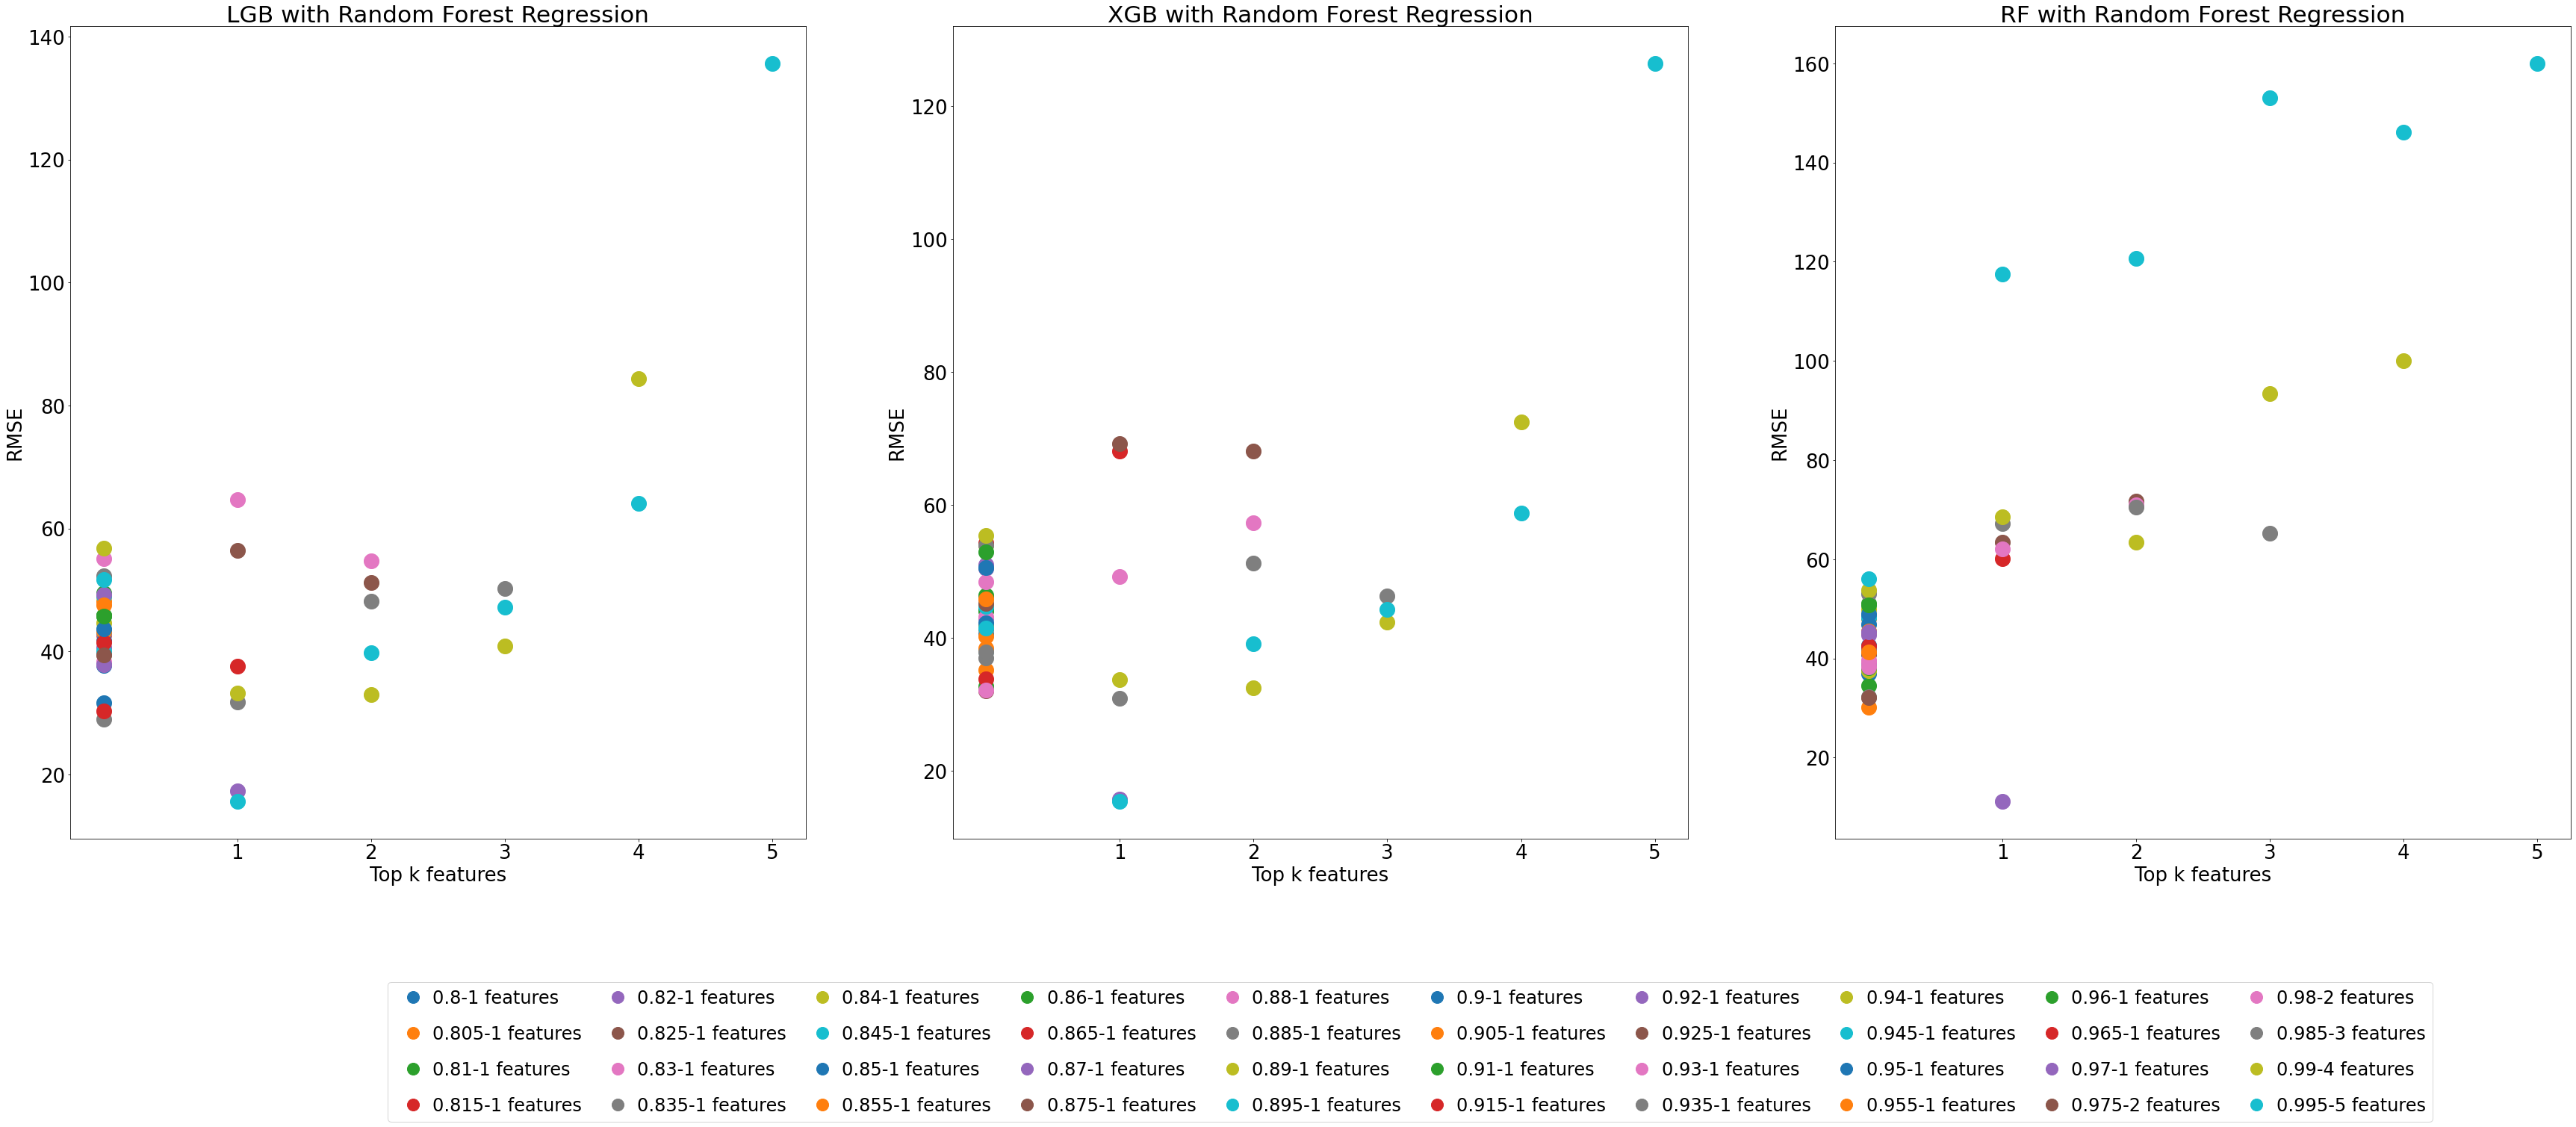

In [476]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with Random Forest Regression")
for k in rfr_lgb_error .keys():
    ax[0].set_xticks(rfr_lgb_error[k].index)
    ax[0].plot(rfr_lgb_error[k]['rmse:'],'o',label = str(k)+"-"+str(len(rfr_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with Random Forest Regression")
for k in rfr_xgb_error .keys():
    ax[1].set_xticks(rfr_xgb_error[k].index)
    ax[1].plot(rfr_xgb_error[k]['rmse:'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with Random Forest Regression")
for k in rfr_rfr_error.keys():
    ax[2].set_xticks(rfr_rfr_error[k].index)
    ax[2].plot(rfr_rfr_error[k]['rmse:'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [41]:
def Linear_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear_a = reg_Linear.predict(x_test)
    y_Linear_a_inverse =minmax_y_test.inverse_transform(y_Linear_a.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    }
    return error_metrics

In [42]:
y_all = Linear_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  4606.887558676757 mae: 3538.9907542936025


In [43]:
Linear_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  6212.825731256011 mae: 5389.984684511669


{'rmse': 6212.825731256011, 'mae': 5389.984684511669}

In [79]:
li_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    li_lgb_error[k] = []
    if type(v)==list:
        li_lgb_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_lgb_error[k] = pd.DataFrame(li_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_lgb_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_lgb_error[k] = pd.DataFrame(li_lgb_error[k],index = list(v.keys()))

li_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    li_xgb_error[k] = []
    if type(v)==list:
        li_xgb_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_xgb_error[k] = pd.DataFrame(li_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_xgb_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_xgb_error[k] = pd.DataFrame(li_xgb_error[k],index = list(v.keys()))
    
li_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    li_rfr_error[k] = []
    if type(v) == list:
        li_rfr_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_rfr_error[k] = pd.DataFrame(li_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_rfr_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_rfr_error[k] = pd.DataFrame(li_rfr_error[k],index = list(v.keys()))

0.5
1 4
rmse:  2794.6622618670403 mae: 1520.077671438677
2 6
rmse:  2948.4400481974403 mae: 1368.7963544422548
0.55
1 3
rmse:  3068.2970989508735 mae: 1446.6619648353676
2 5
rmse:  3154.0243568758046 mae: 1486.790152733739
0.6
1 4
rmse:  3273.027846498852 mae: 1944.9365796648565
2 7
rmse:  3143.884644680465 mae: 1974.9576103206143
3 9
rmse:  3609.6973430162857 mae: 2677.4309208364975
4 11
rmse:  3692.788777914414 mae: 2773.004574924152
5 15
rmse:  3671.625331916437 mae: 2540.8029981282957
0.65
1 3
rmse:  3382.5757956315524 mae: 2313.744837763866
2 7
rmse:  3259.525981365543 mae: 1688.4959752460968
3 12
rmse:  3780.467046582939 mae: 2259.5968035448577
4 14
rmse:  4245.514434019496 mae: 3051.6981849428294
5 17
rmse:  4538.963347583937 mae: 3397.272828534744
0.7
1 3
rmse:  3082.148387625276 mae: 1982.3632063378868
2 4
rmse:  3112.761427552124 mae: 2161.1074714686297
3 7
rmse:  3056.6791540803183 mae: 1985.291776518785
4 10
rmse:  3151.4111846500887 mae: 1908.0610809986524
5 13
rmse:  3337

In [86]:
avg_li_lgb = avg_rmse(li_lgb_error)
avg_li_xgb = avg_rmse(li_xgb_error)
avg_li_rfr = avg_rmse(li_rfr_error)

In [87]:
avg_li_lgb,avg_li_xgb,avg_li_rfr 

(3257.072, 3257.072, 3224.883)

In [81]:
import copy

In [89]:
li_lgb_error[0.5]

,rmse,mae
1,2794.662262,1520.077671
2,2948.440048,1368.796354


In [92]:
mean(li_lgb.values)

nan

In [95]:
li_lgb = join_err(li_lgb_error)
li_xgb = join_err(li_xgb_error)
li_rfr = join_err(li_rfr_error)

Min 2794.6622618670403
Min 2794.6622618670403
Min 2779.5960103673815


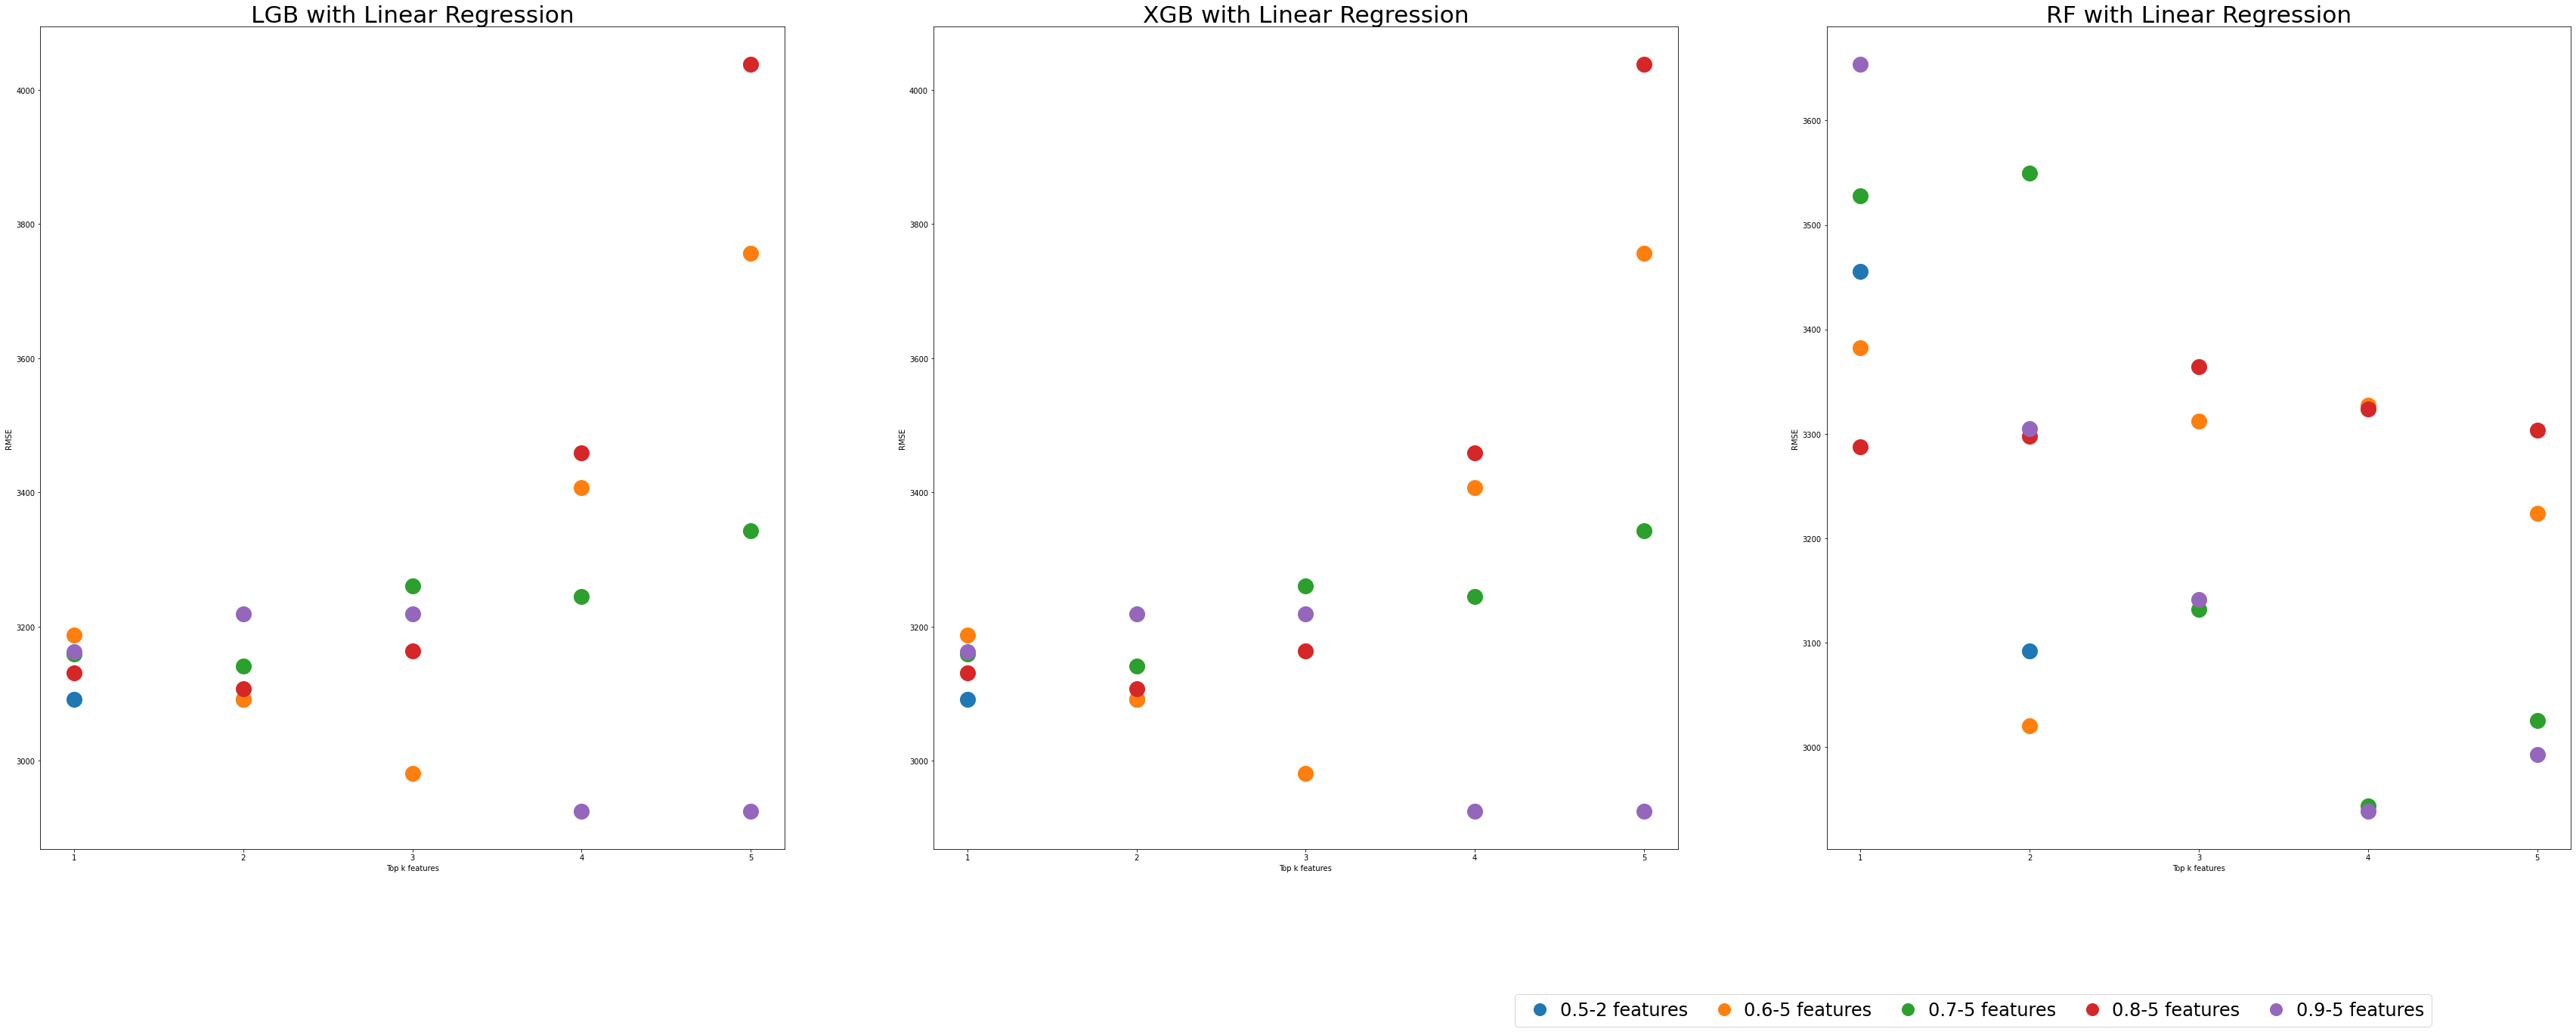

In [60]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    ax[0].set_xticks(li_lgb_error[k].index)
    ax[0].plot(li_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    ax[1].set_xticks(li_xgb_error[k].index)
    ax[1].plot(li_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with Linear Regression")
for k in li_rfr_error.keys():
    ax[2].set_xticks(li_rfr_error[k].index)
    ax[2].plot(li_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

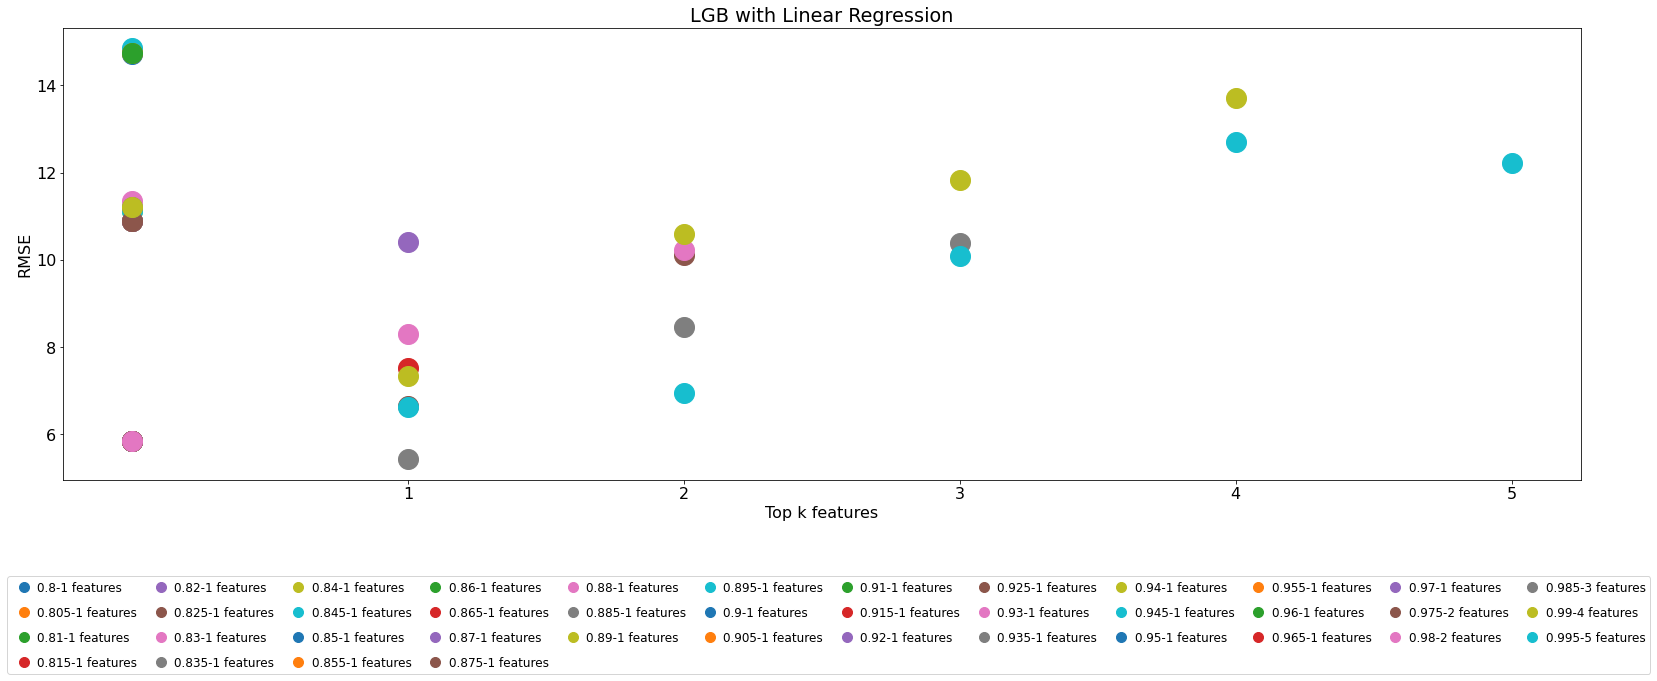

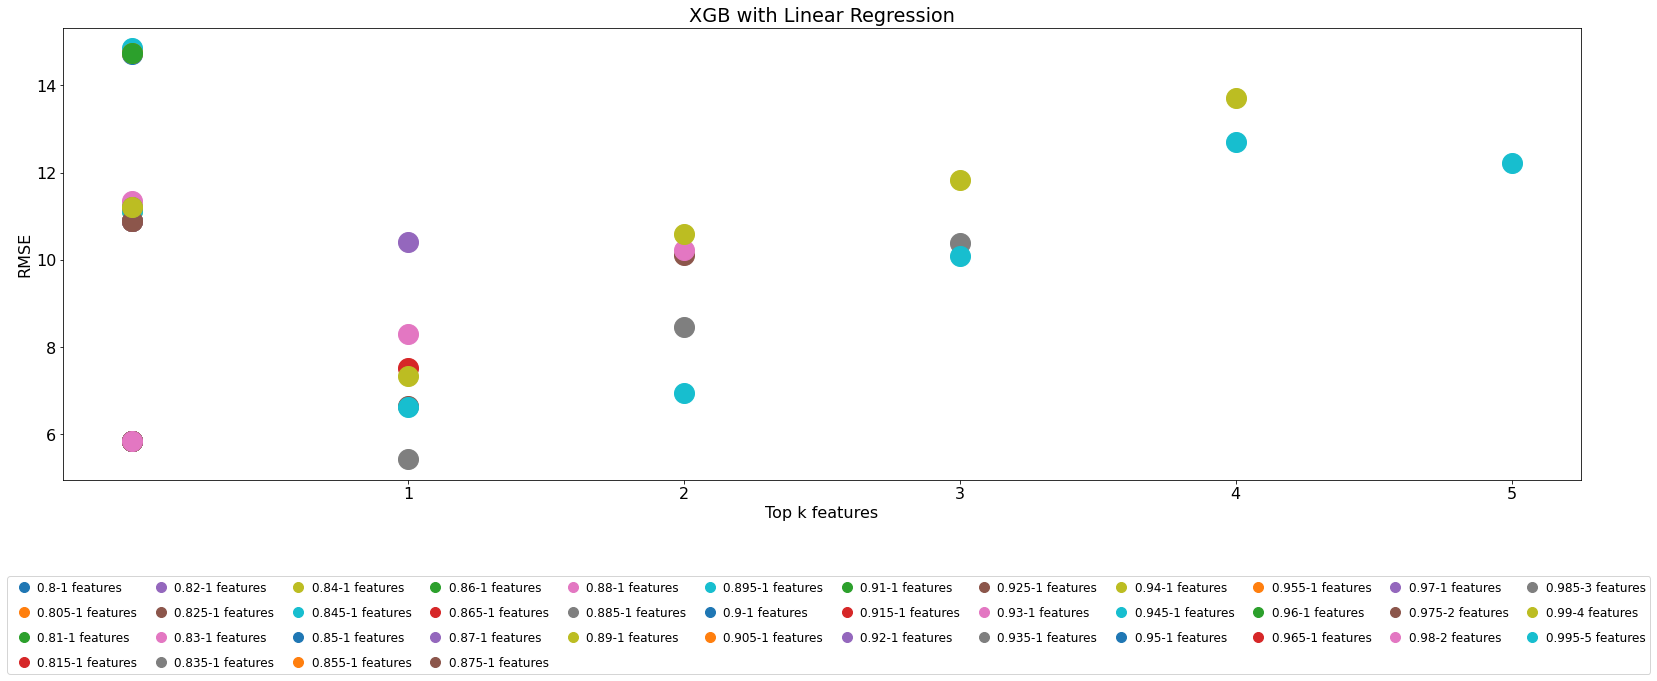

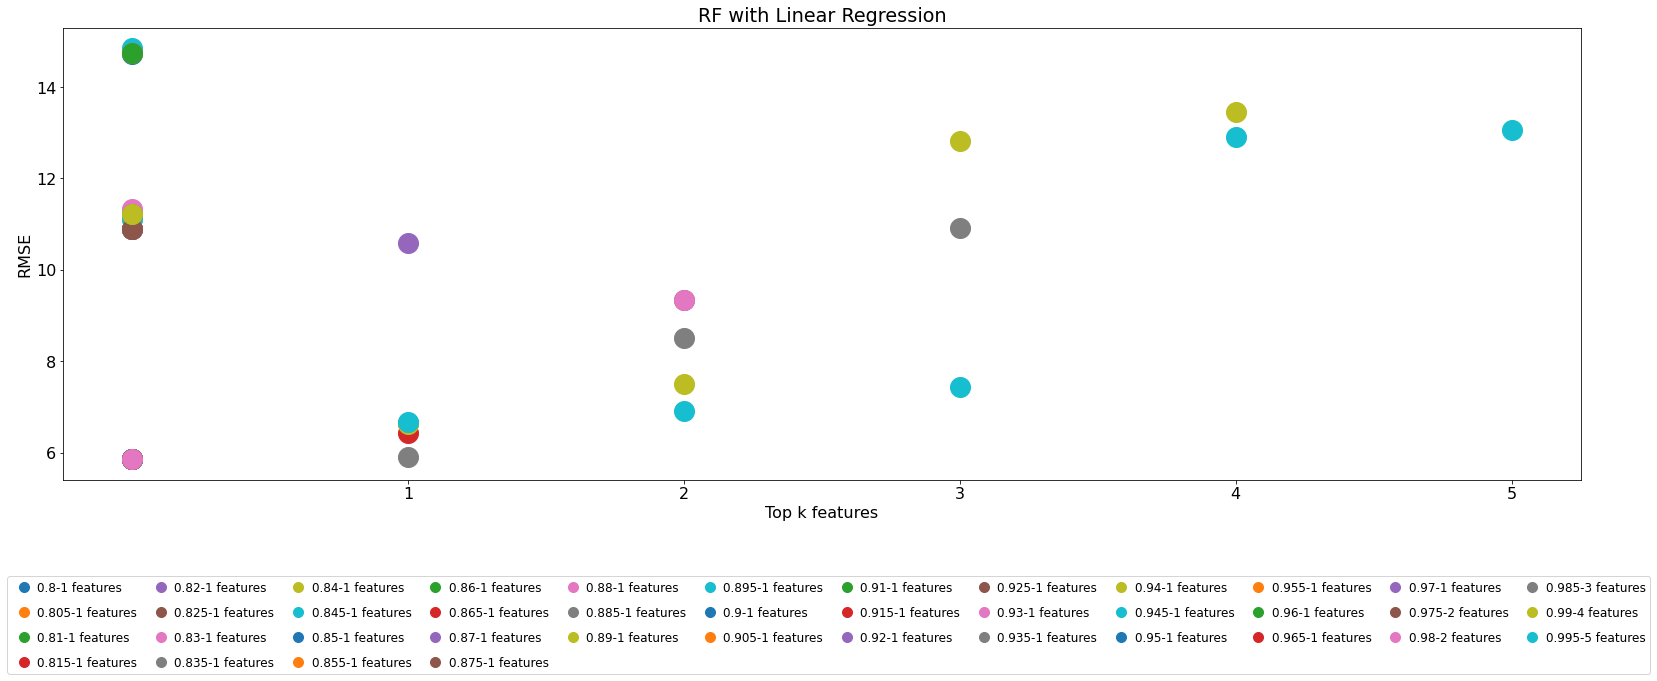

In [359]:
plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'
plt.title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    plt.xticks(li_lgb_error[k].index)
    plt.plot(li_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    plt.xticks(li_xgb_error[k].index)
    plt.plot(li_xgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()


plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("RF with Linear Regression")
for k in li_rfr_error.keys():
    plt.xticks(li_rfr_error[k].index)
    plt.plot(li_rfr_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_rfr_error[k]))+' features',markersize = 20)  
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()

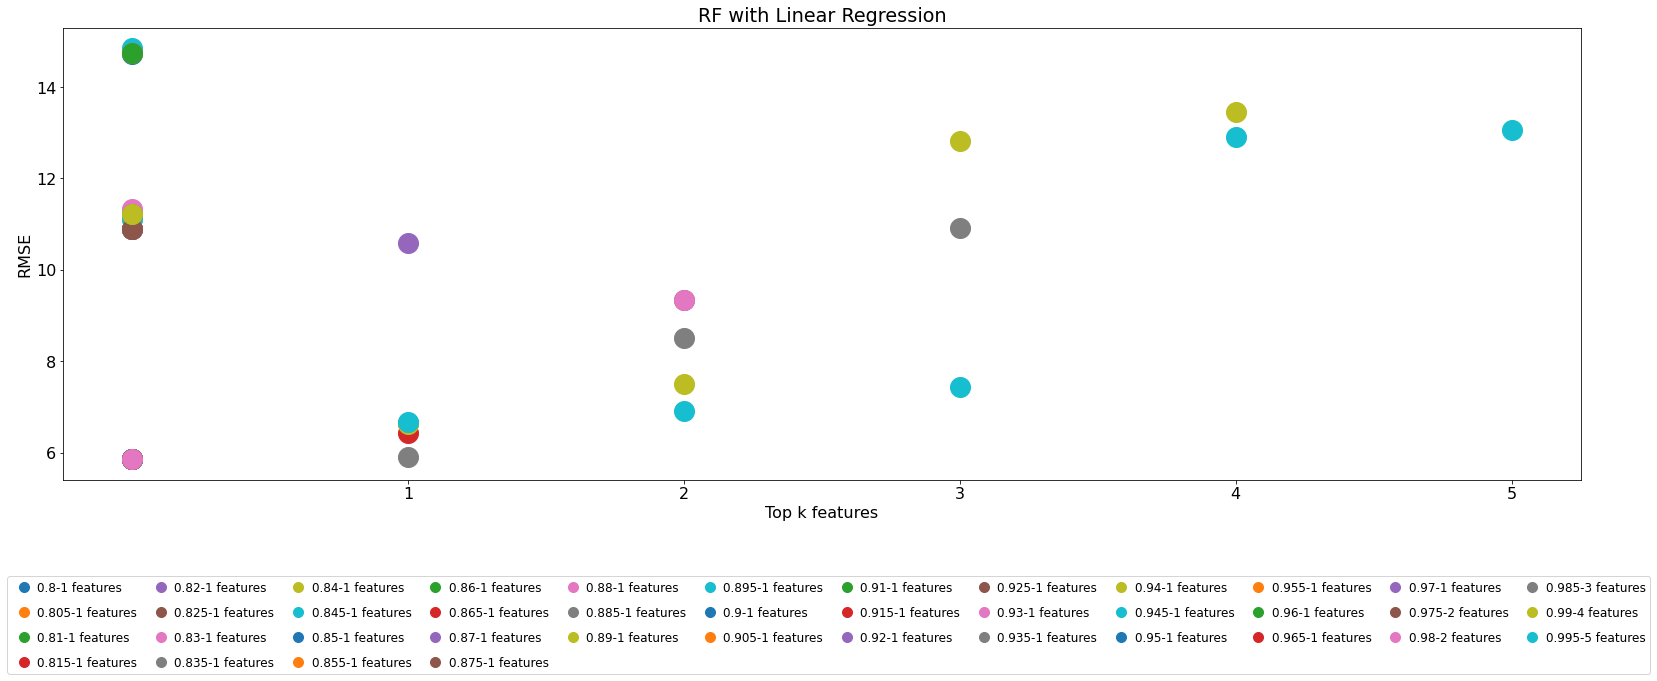

In [358]:
plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("RF with Linear Regression")
for k in li_rfr_error.keys():
    plt.xticks(li_rfr_error[k].index)
    plt.plot(li_rfr_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_rfr_error[k]))+' features',markersize = 20)  
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()

### Support Vector Regression

In [103]:
def SVR_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    parameters = {'kernel':['rbf'], 'gamma':np.logspace(-5, 0, num=6, base=2.0),'C':np.logspace(-5, 5, num=11, base=2.0)}
    svr =  SVR()
    grid_search = GridSearchCV(svr, parameters, cv=10, n_jobs=4, scoring='neg_mean_squared_error')
    grid_search.fit(x_train,y_train.reshape(-1,))
#     print(grid_search.best_params_)
    y_svr = grid_search.predict(x_test)
    
    y_svr_inverse =minmax_y_test.inverse_transform(y_svr.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_svr_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_svr_inverse,y_test_inverse)
    }
    
    return error_metrics

In [119]:
SVR_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  157.43953326887132 mae: 123.37024491531102


{'rmse': 157.43953326887132, 'mae': 123.37024491531102}

In [120]:
SVR_Regressor(x_train_L,y_train_L,x_test_L,y_test_L)

rmse:  186.017125568089 mae: 135.01587709083591


{'rmse': 186.017125568089, 'mae': 135.01587709083591}

In [104]:
svr_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    svr_lgb_error[k] = []
    if type(v)==list:
        svr_lgb_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_lgb_error[k] = pd.DataFrame(svr_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_lgb_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_lgb_error[k] = pd.DataFrame(svr_lgb_error[k],index = list(v.keys()))

svr_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    svr_xgb_error[k] = []
    if type(v)==list:
        svr_xgb_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_xgb_error[k] = pd.DataFrame(svr_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_xgb_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_xgb_error[k] = pd.DataFrame(svr_xgb_error[k],index = list(v.keys()))
    
svr_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    svr_rfr_error[k] = []
    if type(v) == list:
        svr_rfr_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_rfr_error[k] = pd.DataFrame(svr_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_rfr_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_rfr_error[k] = pd.DataFrame(svr_rfr_error[k],index = list(v.keys()))

0.8
rmse:  46.84197320792684 mae: 38.29909024127113
0.805
rmse:  46.84197320792684 mae: 38.29909024127113
0.81
rmse:  46.84197320792684 mae: 38.29909024127113
0.815
rmse:  46.84197320792684 mae: 38.29909024127113
0.82
rmse:  46.84197320792684 mae: 38.29909024127113
0.825
rmse:  46.84197320792684 mae: 38.29909024127113
0.83
rmse:  46.84197320792684 mae: 38.29909024127113
0.835
rmse:  46.84197320792684 mae: 38.29909024127113
0.84
rmse:  46.84197320792684 mae: 38.29909024127113
0.845
rmse:  46.84197320792684 mae: 38.29909024127113
0.85
rmse:  46.84197320792684 mae: 38.29909024127113
0.855
rmse:  46.84197320792684 mae: 38.29909024127113
0.86
rmse:  46.84197320792684 mae: 38.29909024127113
0.865
rmse:  46.84197320792684 mae: 38.29909024127113
0.87
rmse:  46.84197320792684 mae: 38.29909024127113
0.875
rmse:  46.84197320792684 mae: 38.29909024127113
0.88
rmse:  46.84197320792684 mae: 38.29909024127113
0.885
rmse:  37.953163293522756 mae: 31.837371899375494
0.89
rmse:  37.953163293522756 mae: 

rmse:  119.33497074881441 mae: 80.64684109468139
5 14
rmse:  116.59467158900426 mae: 76.51610033981042


In [108]:
avg_svr_lgb = avg_rmse(svr_lgb_error)
avg_svr_xgb = avg_rmse(svr_xgb_error)
avg_svr_rfr = avg_rmse(svr_rfr_error)

avg_svr_lgb,avg_svr_xgb,avg_svr_rfr 

(61.599, 61.599, 59.088)

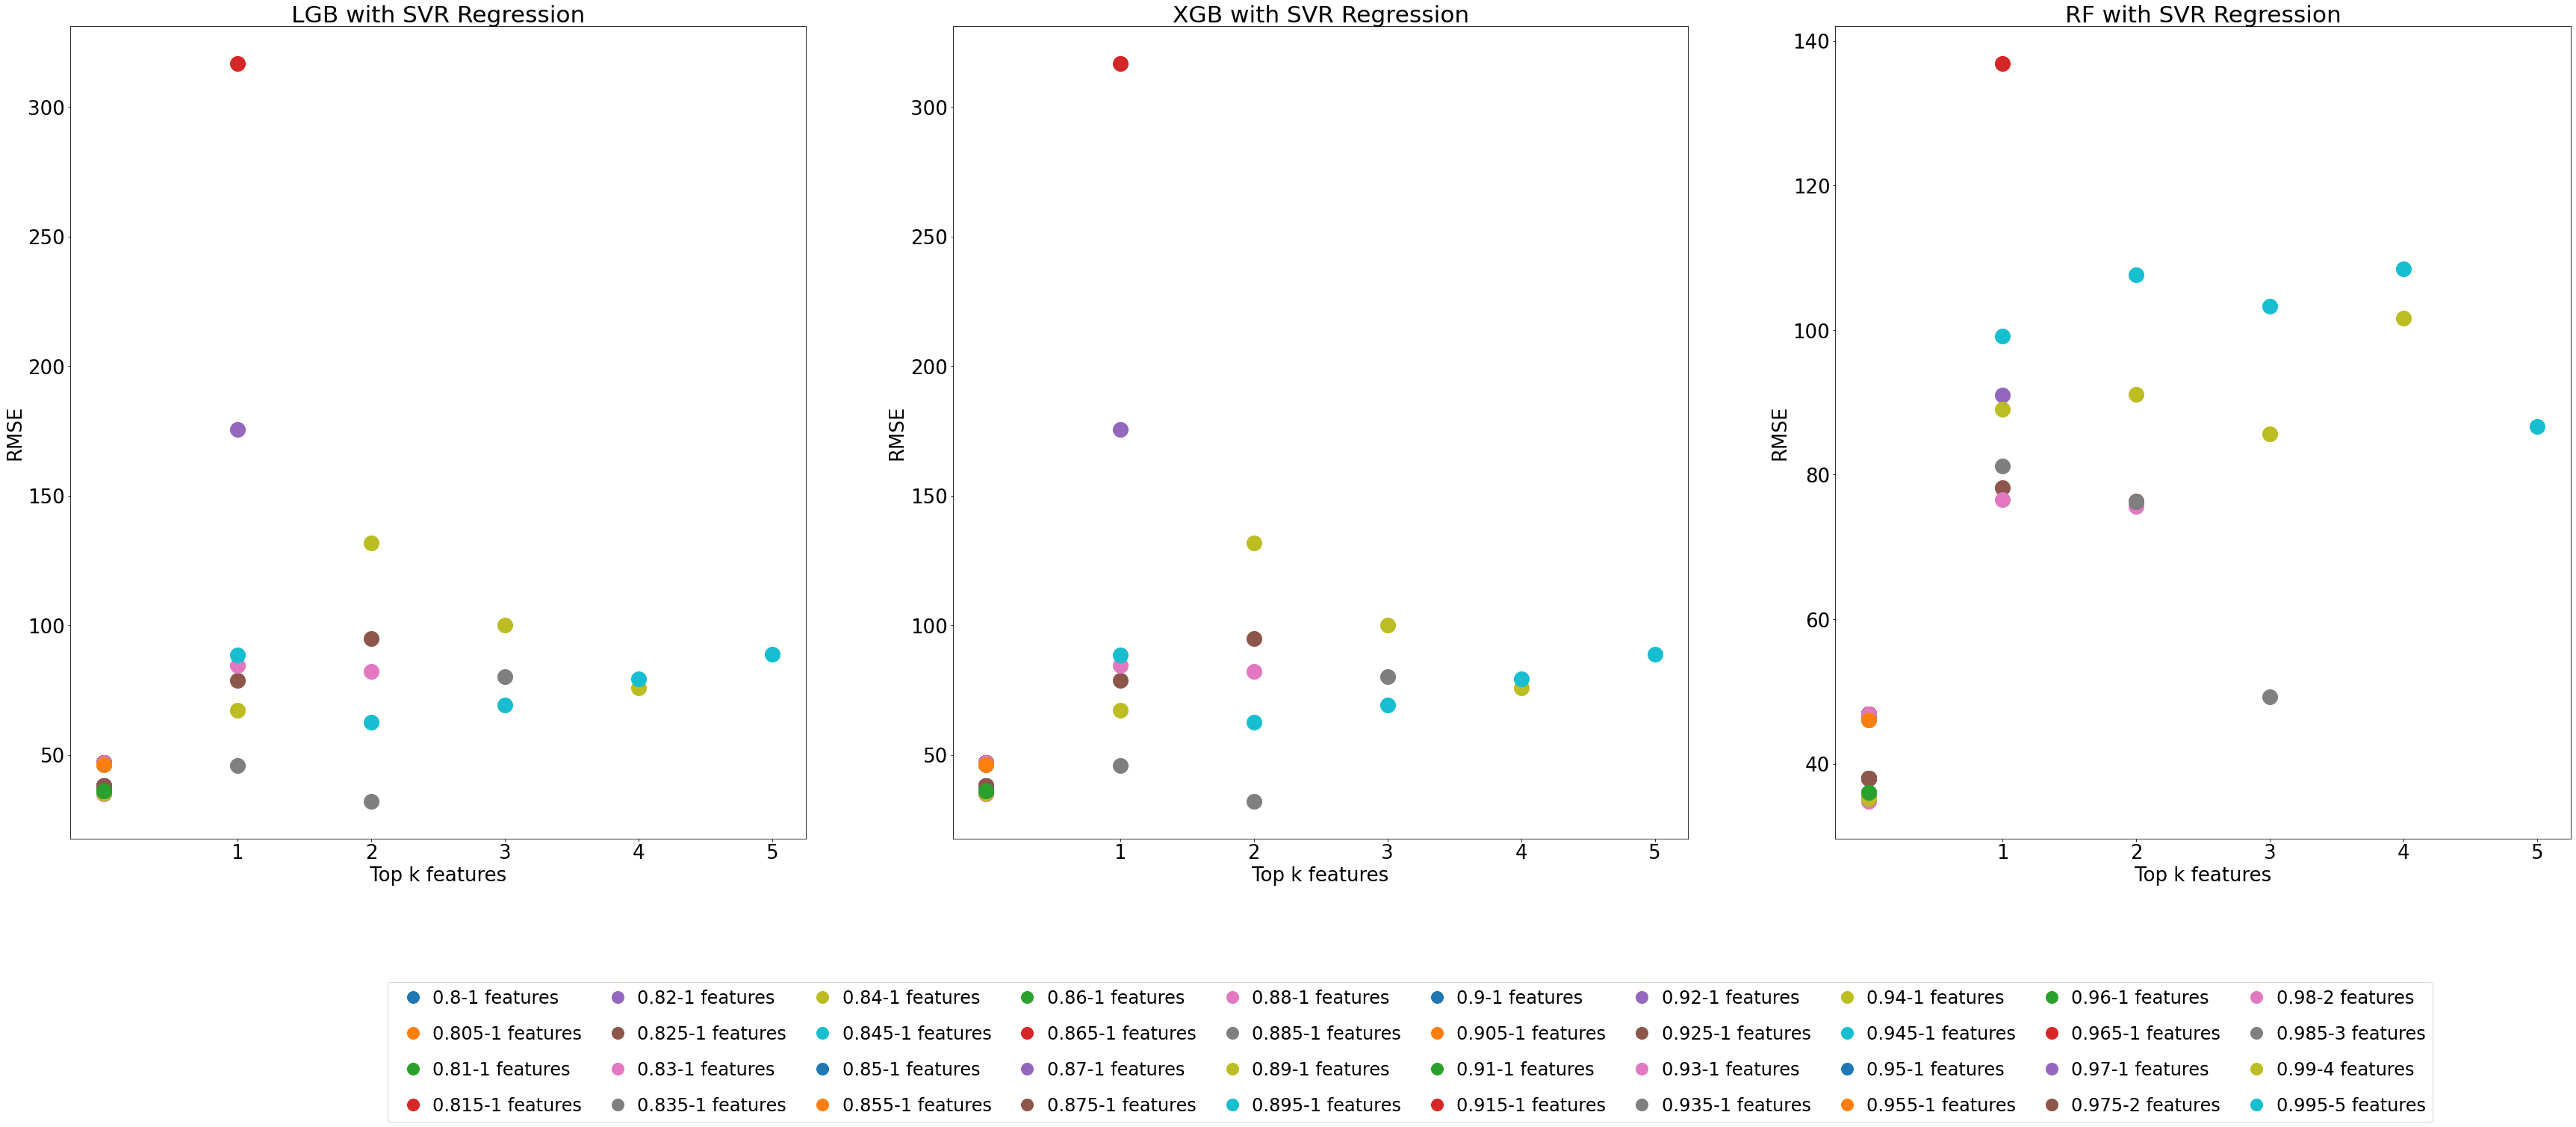

In [459]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with SVR Regression")
for k in svr_lgb_error .keys():
    ax[0].set_xticks(svr_lgb_error[k].index)
    ax[0].plot(svr_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(svr_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with SVR Regression")
for k in svr_xgb_error .keys():
    ax[1].set_xticks(svr_xgb_error[k].index)
    ax[1].plot(svr_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with SVR Regression")
for k in svr_rfr_error.keys():
    ax[2].set_xticks(svr_rfr_error[k].index)
    ax[2].plot(svr_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [44]:
def xgb_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    xgb = XGBRegressor(n_jobs=-1, n_estimators=100, max_depth=4, random_state=99)
    xgb.fit(x_train,y_train.reshape(-1,))
    y_xgb = xgb.predict(x_test)
    y_xgb_inverse =minmax_y_test.inverse_transform(y_xgb.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_xgb_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_xgb_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_xgb_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_xgb_inverse,y_test_inverse)
    }
    
    return error_metrics

In [45]:
xgb_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  3643.816334949903 mae: 2182.302647010953


{'rmse': 3643.816334949903, 'mae': 2182.302647010953}

In [46]:
xgb_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  4040.841010671606 mae: 3440.5204121579404


{'rmse': 4040.841010671606, 'mae': 3440.5204121579404}

In [97]:
xgb_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    xgb_lgb_error[k] = []
    if type(v)==list:
        xgb_lgb_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_lgb_error[k] = pd.DataFrame(xgb_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_lgb_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_lgb_error[k] = pd.DataFrame(xgb_lgb_error[k],index = list(v.keys()))

xgb_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    xgb_xgb_error[k] = []
    if type(v)==list:
        xgb_xgb_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_xgb_error[k] = pd.DataFrame(xgb_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_xgb_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_xgb_error[k] = pd.DataFrame(xgb_xgb_error[k],index = list(v.keys()))
    
xgb_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    xgb_rfr_error[k] = []
    if type(v) == list:
        xgb_rfr_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_rfr_error[k] = pd.DataFrame(xgb_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_rfr_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_rfr_error[k] = pd.DataFrame(xgb_rfr_error[k],index = list(v.keys()))

0.5
1 4
rmse:  3185.3308853214526 mae: 1379.6282979954956
2 6
rmse:  2880.4345591438487 mae: 1290.9161047243304
0.55
1 3
rmse:  3034.5220756581875 mae: 1340.8173279198268
2 5
rmse:  2575.0921484121427 mae: 1320.4754821818362
0.6
1 4
rmse:  4146.443835610305 mae: 1757.5831965169598
2 7
rmse:  3459.2700176912385 mae: 1524.2723195578462
3 9
rmse:  3163.7481934339417 mae: 1458.1053445518658
4 11
rmse:  3359.0905663267476 mae: 1557.03201055014
5 15
rmse:  3431.4811006172777 mae: 2799.9548883745747
0.65
1 3
rmse:  3760.9158861821393 mae: 2476.4421963025165
2 7
rmse:  3740.9014563099267 mae: 1851.1108100516822
3 12
rmse:  3395.9085692446447 mae: 1627.8123589754105
4 14
rmse:  3388.536552477153 mae: 1632.0493201184017
5 17
rmse:  3246.806595433134 mae: 1581.1242727416177
0.7
1 3
rmse:  3495.2075763131797 mae: 1307.528862589149
2 4
rmse:  3385.4852440955874 mae: 1312.7636545239598
3 7
rmse:  3759.703563035558 mae: 1706.2443614646952
4 10
rmse:  3949.0196595392213 mae: 1953.456207729155
5 13
rms

In [98]:
avg_xgb_lgb = avg_rmse(xgb_lgb_error)
avg_xgb_xgb = avg_rmse(xgb_xgb_error)
avg_xgb_rfr = avg_rmse(xgb_rfr_error)

avg_xgb_lgb,avg_xgb_xgb,avg_xgb_rfr 

(3299.999, 3299.999, 3472.805)

In [99]:
xgb_lgb = join_err(xgb_lgb_error)
xgb_xgb = join_err(xgb_xgb_error)
xgb_rfr = join_err(xgb_rfr_error)

Min 2541.2758251638347
Min 2541.2758251638347
Min 2216.841018353577


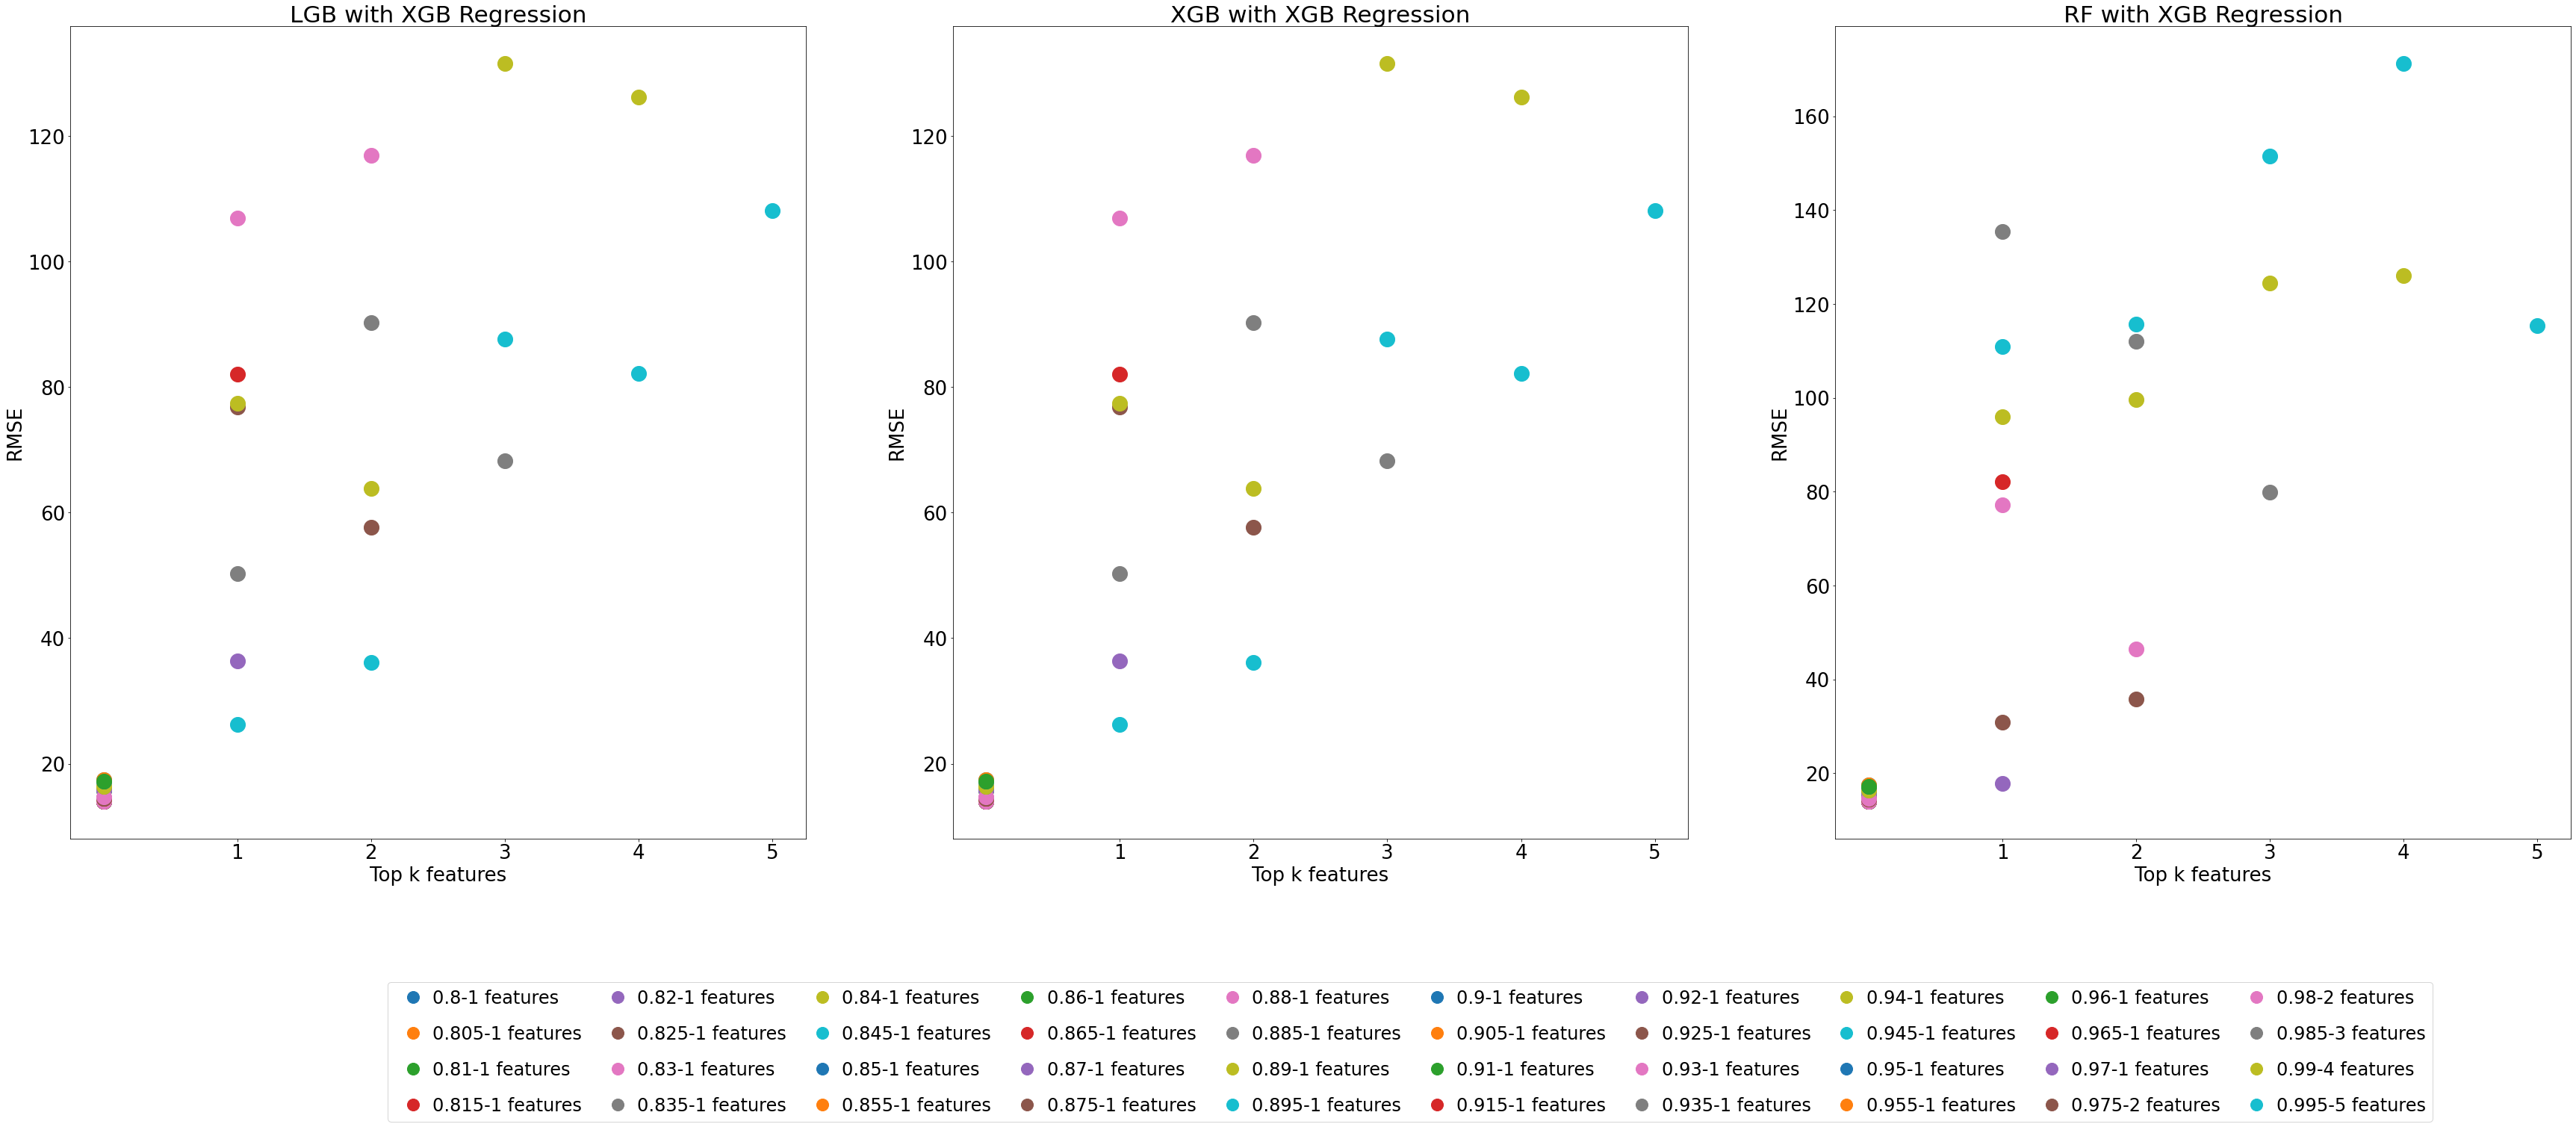

In [457]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with XGB Regression")
for k in xgb_lgb_error .keys():
    ax[0].set_xticks(xgb_lgb_error[k].index)
    ax[0].plot(xgb_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(xgb_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with XGB Regression")
for k in xgb_xgb_error .keys():
    ax[1].set_xticks(xgb_xgb_error[k].index)
    ax[1].plot(xgb_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with XGB Regression")
for k in xgb_rfr_error.keys():
    ax[2].set_xticks(xgb_rfr_error[k].index)
    ax[2].plot(xgb_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [102]:
def lgb_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train)
    y_gbm = gbm.predict(x_test)
    y_gbm_inverse =minmax_y_test.inverse_transform(y_gbm.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_gbm_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_gbm_inverse,y_test_inverse)
    }
    
    
    return error_metrics

In [103]:
lgb_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  3583.3803521144846 mae: 2049.0430717290515


{'rmse': 3583.3803521144846, 'mae': 2049.0430717290515}

In [104]:
lgb_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  3157.414006726933 mae: 1589.8046125874953


{'rmse': 3157.414006726933, 'mae': 1589.8046125874953}

In [105]:
lgb_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    lgb_lgb_error[k] = []
    if type(v)==list:
        lgb_lgb_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_lgb_error[k] = pd.DataFrame(lgb_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_lgb_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_lgb_error[k] = pd.DataFrame(lgb_lgb_error[k],index = list(v.keys()))

lgb_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    lgb_xgb_error[k] = []
    if type(v)==list:
        lgb_xgb_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_xgb_error[k] = pd.DataFrame(lgb_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_xgb_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_xgb_error[k] = pd.DataFrame(lgb_xgb_error[k],index = list(v.keys()))
    
lgb_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    lgb_rfr_error[k] = []
    if type(v) == list:
        lgb_rfr_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_rfr_error[k] = pd.DataFrame(lgb_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_rfr_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_rfr_error[k] = pd.DataFrame(lgb_rfr_error[k],index = list(v.keys()))

0.5
1 4
rmse:  3107.390315825853 mae: 1477.4963543048354
2 6
rmse:  3011.610511534076 mae: 1547.6621896301788
0.55
1 3
rmse:  2977.848158319601 mae: 1536.873273208259
2 5
rmse:  2867.1130874978007 mae: 1696.7712399267634
0.6
1 4
rmse:  3577.141285599363 mae: 1647.163225596938
2 7
rmse:  3117.509100625617 mae: 1758.6810898335964
3 9
rmse:  3012.6778310711798 mae: 1491.8525575449007
4 11
rmse:  3042.52920848006 mae: 1525.382563080665
5 15
rmse:  2913.262921504227 mae: 1452.3941252850518
0.65
1 3
rmse:  3646.7404337871226 mae: 2461.1553342677043
2 7
rmse:  3446.633172304019 mae: 1875.364594925599
3 12
rmse:  3256.683172499587 mae: 1684.9445544054402
4 14
rmse:  3580.8162636446596 mae: 1938.0456992490433
5 17
rmse:  3608.2475327194875 mae: 1815.558512765743
0.7
1 3
rmse:  2978.9944909292685 mae: 1431.9827367044945
2 4
rmse:  3013.7036897021985 mae: 1613.1315605634925
3 7
rmse:  3235.912340232339 mae: 1815.5674751921722
4 10
rmse:  3762.2858342312243 mae: 2216.793249147751
5 13
rmse:  3584.

In [106]:
avg_lgb_lgb = avg_rmse(lgb_lgb_error)
avg_lgb_xgb = avg_rmse(lgb_xgb_error)
avg_lgb_rfr = avg_rmse(lgb_rfr_error)

avg_lgb_lgb,avg_lgb_xgb,avg_lgb_rfr 

(3081.122, 3081.122, 2962.761)

In [107]:
lgb_lgb = join_err(lgb_lgb_error)
lgb_xgb = join_err(lgb_xgb_error)
lgb_rfr = join_err(lgb_rfr_error)

Min 2483.8164260581225
Min 2483.8164260581225
Min 2324.2386054770823


In [1]:
fig.tight_layout()
fig.text(0.5, -0.02, 'Top k features', ha='center',fontsize=50)
fig.text(-0.02, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=50)
fig.legend(list(real_lgb.keys()),scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.8,-0.03),ncol=10,handletextpad=4,fontsize=50)
plt.savefig('rmse_diamond.png')
plt.show()

NameError: name 'plt' is not defined